In [1]:
import pygyre as pg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob

# We've run GYRE on a number of MESA runs (where here number=1, but will be eventually), all based on a fiducial 21 $M_\odot$ model. In this model, we crank up the ''$\mathrm{Dutch\_scaling\_factor}$'' ($\eta$) by a factor of 5 (from 0.8 to 4.0) once the star has reached the effective temperature of a K supergiant (5200 K). It loses a good chunk of its envelope during the RSG phase, then evolves back across the HR diagram. Once it's warmed up past 5200 K again, we scale $\eta$ down to 2.0. Here's the MESA model, colored by $\eta$:

In [2]:
#MESA Logs
l_start = '../21M_mesa/LOGS_start/'
l_to_10kK = '../21M_mesa/LOGS_to_10kK/'
l_to_rsg = '../21M_mesa/LOGS_to_rsg/'
l_rsg = '../21M_mesa/LOGS_rsg/'
l_postrsg = '../21M_mesa/LOGS_postrsg/'

def read_history(logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    hist = pd.read_csv(logs+'history.data',sep='\s+',skiprows=5)
    evo_stage = '_'.join(logs.split('_')[1:]).rstrip('/')
    hist['EvoStage'] = [evo_stage for i in range(len(hist))]
    hist['LOGS'] = [logs for i in range(len(hist))]
    
    return hist

def read_profile_index(logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    profile_index = pd.read_csv(logs+'profiles.index',
                                names=['model_number','priority','profile_num'],
                                sep='\s+',skiprows=1)
    evo_stage = '_'.join(logs.split('/')[-2].split('_')[1:]).rstrip('/')
    profile_index['EvoStage'] = [evo_stage for i in range(len(profile_index))]
    profile_index['LOGS'] = [logs for i in range(len(profile_index))]
    
    return profile_index

all_hist = pd.concat([read_history(l) for l in [l_start,l_to_10kK,l_to_rsg,l_rsg,l_postrsg]]).reset_index(drop=True)
all_index = pd.concat([read_profile_index(l) for l in [l_start,l_to_10kK,l_to_rsg,l_rsg,l_postrsg]]).reset_index(drop=True)

Text(0, 0.5, '$\\log L/L_\\odot$')

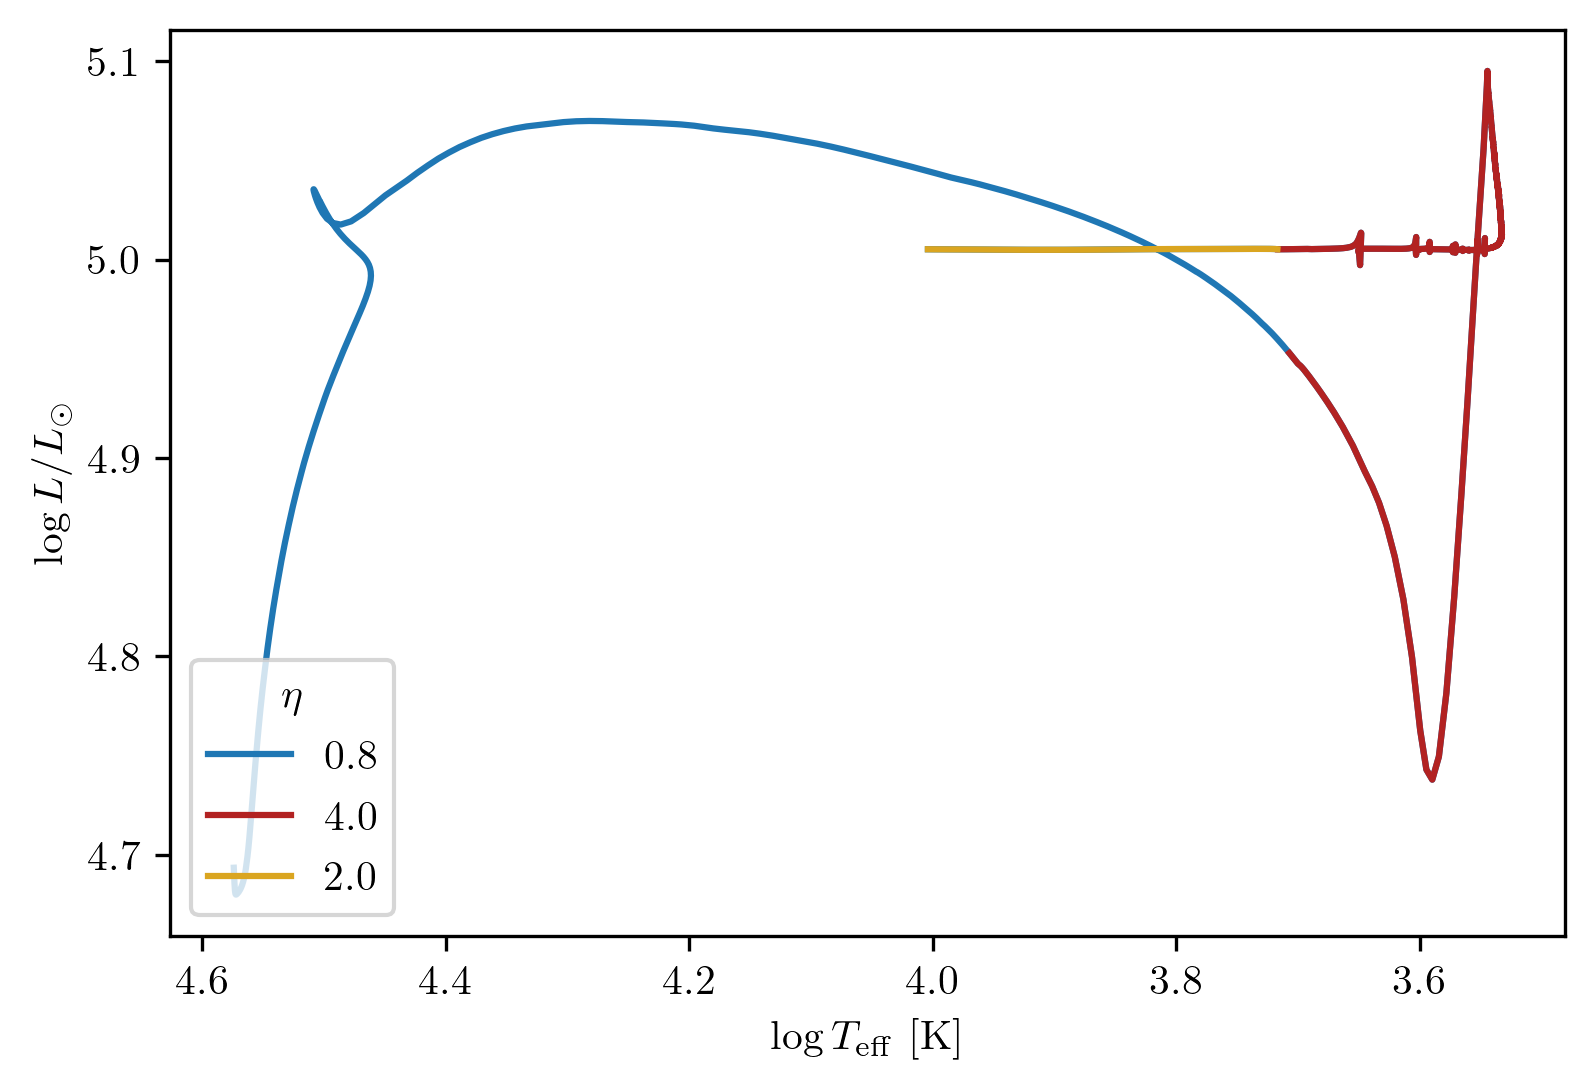

In [3]:
post_zams = all_hist[all_hist['LOGS'] != l_start]
rsg = all_hist[all_hist['LOGS'] == l_rsg]
postrsg = all_hist[all_hist['LOGS'] == l_postrsg]
fig = plt.figure(dpi=300)
plt.plot(post_zams['log_Teff'],post_zams['log_L'],label='$0.8$')
plt.plot(rsg['log_Teff'],rsg['log_L'],label='$4.0$',c='firebrick')
plt.plot(postrsg['log_Teff'],postrsg['log_L'],label='$2.0$',c='goldenrod')

plt.gca().invert_xaxis()
plt.legend(loc='lower left',title=r'$\eta$')

plt.xlabel(r'$\log T_{\rm eff}$ [K]')
plt.ylabel(r'$\log L/L_\odot$')

# We then ran GYRE on the model as it first crosses the HR diagram, and as it makes its way back. We also tried two different boundary conditions: one with `outer_bound = 'ISOTHERMAL'`, the other with `outer_bound = 'UNNO'` and `outer_bound_branch = 'F_NEG'` (i.e., only outward traveling waves with no reflection).

In [5]:
#GYRE outputs
l_21_uno_pre = './21M_prersg_unno/' #Run on pre-rsg stage
l_21_iso = './21M_isothermal/' #Run with isothermal BC
l_21_uno = './21M_Unno_Fneg/' #Run with Unno BC

g_to_m_dict = {l_21_iso:'../21M_mesa/',l_21_uno:'../21M_mesa/',l_21_uno_pre:'../21M_mesa/'} #map GYRE output to MESA model

def read_summary(logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    mesa_hist = pd.concat([read_history(l) for l in glob(g_to_m_dict[logs]+'LOGS_*/')]).reset_index(drop=True)
    mesa_index = pd.concat([read_profile_index(l) for l in glob(g_to_m_dict[logs]+'LOGS_*/')]).reset_index(drop=True)
    
    summaries = glob(logs+'*summary*')
    prof_nums = []
    teffs = []
    tdyns = []
    tkhs = []
    num_excited = []
    for summ in summaries:
        prof_num = summ.split('/')[-1].split('_')[-1].split('.')[0]
        prof_nums.append(int(prof_num))
        
        if logs == l_21_uno_pre:
            mod_num = mesa_index[(mesa_index['EvoStage']=='to_rsg')&(mesa_index['profile_num']==int(prof_num))]['model_number'].values[0]
            this_hist = mesa_hist[mesa_hist['model_number']==mod_num]
        else:
            mod_num = mesa_index[(mesa_index['EvoStage']=='postrsg')&(mesa_index['profile_num']==int(prof_num))]['model_number'].values[0]
            this_hist = mesa_hist[mesa_hist['model_number']==mod_num]
        teff = this_hist['log_Teff'].values[0]
        teffs.append(teff)
        tdyns.append(this_hist['dynamic_timescale'].values[0])
        tkhs.append(this_hist['kh_timescale'].values[0])
    
        s = pg.read_output(summ)
        good = s[s['freq'].imag > 0]
        num_excited.append(len(good))
       
    out_df = pd.DataFrame({'SummaryFile':summaries,'ProfileNumber':prof_nums,'Teff':teffs,
                           'TauDyn':tdyns,'TauKH':tkhs,'NumExcited':num_excited})
    out_df['Directory'] = [logs for i in range(len(summaries))]
    out_df.sort_values('ProfileNumber',inplace=True)
    return out_df.reset_index(drop=True)

iso_unno_compare = pd.concat([read_summary(l) for l in [l_21_iso,l_21_uno]])
all_sum = pd.concat([read_summary(l) for l in [l_21_uno]])

In [6]:
def read_excited(summaries=None):
    if summaries is None:
        raise OSError('Summary does not exist')
    
    summary_files = []
    directories = []
    prof_excited = []
    teffs_good = []
    tdyns_good = []
    tkhs_good = []
    ng_good = []
    np_good = []
    npg_good = []
    freq_good = []
    omegr_good = []
    omegi_good = []
    
    for i, summ in summaries.iterrows():
        s = pg.read_output(summ['SummaryFile'])
        good = s[s['freq'].imag > 0]
        if len(good) == 0:
            continue
        for row,g in good.to_pandas().iterrows():
            summary_files.append(summ['SummaryFile'])
            directories.append(summ['Directory'])
            prof_excited.append(summ['ProfileNumber'])
            teffs_good.append(summ['Teff'])
            tdyns_good.append(summ['TauDyn'])
            tkhs_good.append(summ['TauKH'])

            ng_good.append(g['n_g'].real)
            np_good.append(g['n_p'].real)
            npg_good.append(g['n_pg'].real)

            freq_good.append(g['freq'].real)
            omegr_good.append(g['omega'].real)
            omegi_good.append(g['omega'].imag)
        
    out_df = pd.DataFrame({'SummaryFile':summary_files,'Directory':directories,'ProfileNumber':prof_excited,
                           'Teff':teffs_good,'TauDyn':tdyns_good,'TauKH':tkhs_good,
                           'n_p':np_good,'n_g':ng_good,'n_pg':npg_good,
                           'Freq':freq_good,'OmegaR':omegr_good,'OmegaI':omegi_good})
    return out_df
        
compare_excited = read_excited(summaries=iso_unno_compare)
all_excited = read_excited(summaries=all_sum)
all_excited

,SummaryFile,Directory,ProfileNumber,Teff,TauDyn,TauKH,n_p,n_g,n_pg,Freq,OmegaR,OmegaI
0,./21M_Unno_Fneg/summary_21.h5,./21M_Unno_Fneg/,21,3.771313,1.928708e+07,43.693426,406.0,12.0,395.0,1.964646,438.568164,1.085351
1,./21M_Unno_Fneg/summary_26.h5,./21M_Unno_Fneg/,26,3.788901,1.708480e+07,47.330771,30.0,237.0,-207.0,0.218304,43.167545,0.013757
2,./21M_Unno_Fneg/summary_31.h5,./21M_Unno_Fneg/,31,3.806833,1.509780e+07,51.354669,7.0,46.0,-39.0,1.115539,194.932668,0.000404
3,./21M_Unno_Fneg/summary_36.h5,./21M_Unno_Fneg/,36,3.822264,1.357324e+07,55.097633,41.0,162.0,-121.0,0.322935,50.732394,0.041394
4,./21M_Unno_Fneg/summary_41.h5,./21M_Unno_Fneg/,41,3.838781,1.211022e+07,59.421686,45.0,142.0,-97.0,0.372078,52.152160,0.027610
5,./21M_Unno_Fneg/summary_46.h5,./21M_Unno_Fneg/,46,3.855131,1.081710e+07,64.040051,31.0,225.0,-194.0,0.222523,27.859450,0.079965
6,./21M_Unno_Fneg/summary_56.h5,./21M_Unno_Fneg/,56,3.887075,8.676738e+06,74.104315,23.0,218.0,-195.0,0.233787,23.478078,0.056895
7,./21M_Unno_Fneg/summary_61.h5,./21M_Unno_Fneg/,61,3.903376,7.753979e+06,79.825425,12.0,217.0,-205.0,0.234841,21.075814,0.051521
8,./21M_Unno_Fneg/summary_61.h5,./21M_Unno_Fneg/,61,3.903376,7.753979e+06,79.825425,58.0,77.0,-19.0,0.698038,62.645519,0.004048
9,./21M_Unno_Fneg/summary_66.h5,./21M_Unno_Fneg/,66,3.919627,6.931917e+06,85.964819,39.0,224.0,-185.0,0.210002,16.848535,0.054509


# We find that no modes are excited as the star crosses the HR diagram, with the exception of a single mode at the hot end, more-or-less consistent with Saio+(2013), and one p-mode at the cold end.

Text(0, 0.5, 'Number of Excited Modes')

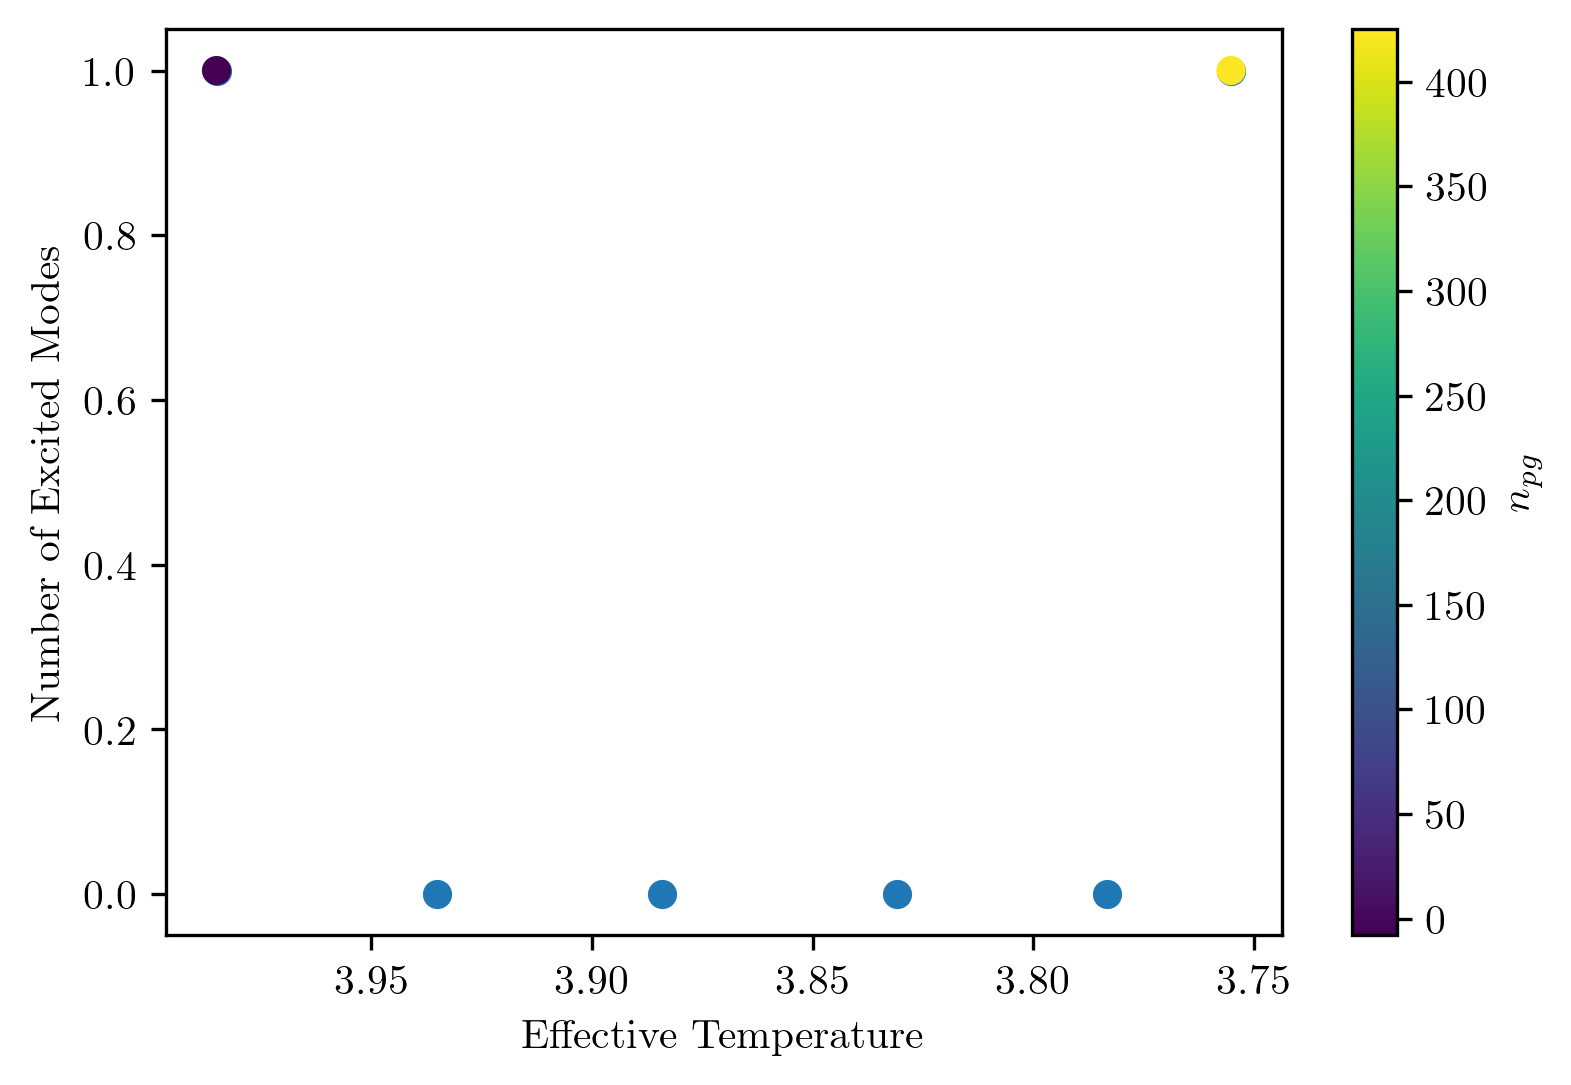

In [7]:
pre_summ = read_summary(logs='./21M_prersg_unno/')
pre_excited = read_excited(summaries=pre_summ)
fig = plt.figure(dpi=300)
plt.scatter(pre_summ['Teff'],pre_summ['NumExcited'])
plt.scatter(pre_excited['Teff'],[1.0 for _ in pre_excited.iterrows()],c=pre_excited['n_pg'])
plt.colorbar(label=r'$n_{pg}$')
plt.gca().invert_xaxis()
plt.xlabel('Effective Temperature')
plt.ylabel('Number of Excited Modes')

# However, on its way back, lots more modes get excited! Here we compare the results between two different boundary conditions. Modes get excited in roughly the same model time steps, but the number of modes varies between the two runs

Text(0, 0.5, 'Number of excited modes')

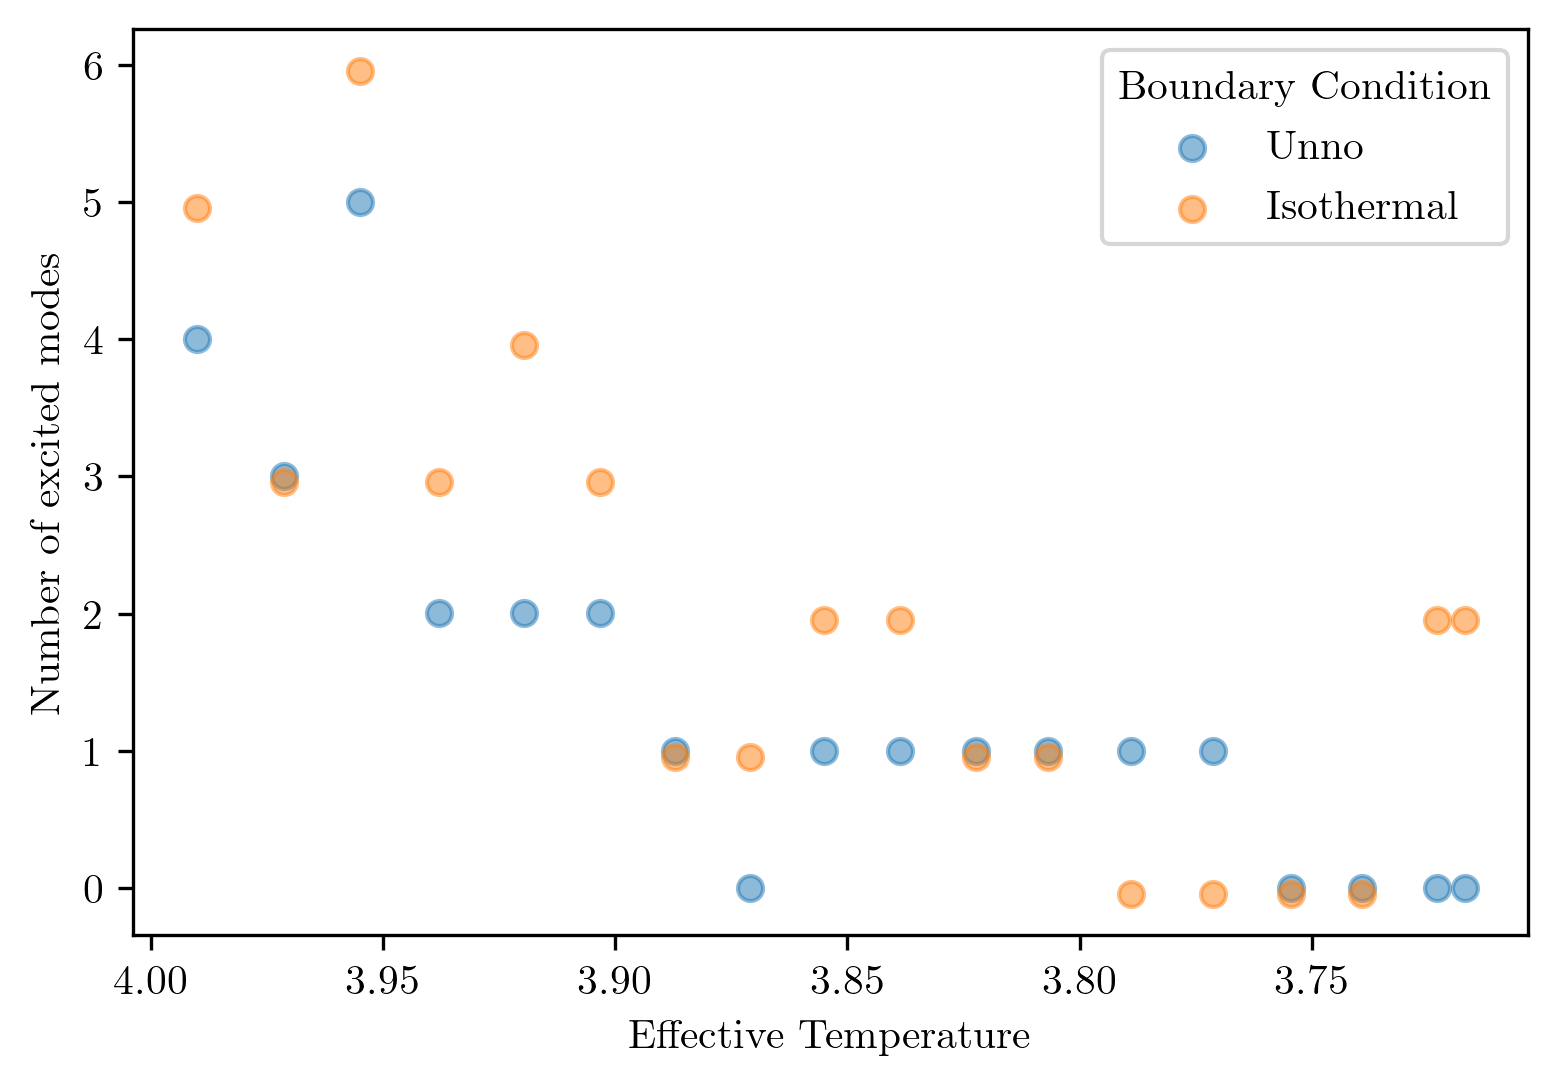

In [372]:
fig = plt.figure(dpi=300)
d_lab_dict = {l_21_iso:'Isothermal',l_21_uno:'Unno'}
for d,df in iso_unno_compare.groupby('Directory'):
    plt.scatter(df['Teff'],df['NumExcited']+0.05*np.random.randn(),alpha=0.5,label=d_lab_dict[d])

plt.legend(title='Boundary Condition')
plt.gca().invert_xaxis()
    
plt.xlabel(r'Effective Temperature')
plt.ylabel('Number of excited modes')

# Looking at just the Unno boundary condition run on the 21 $M_\odot$ model, we find modes all across the range expected in FYPS! 

Text(0, 0.5, '$\\log T_{\\rm eff}$ [K]')

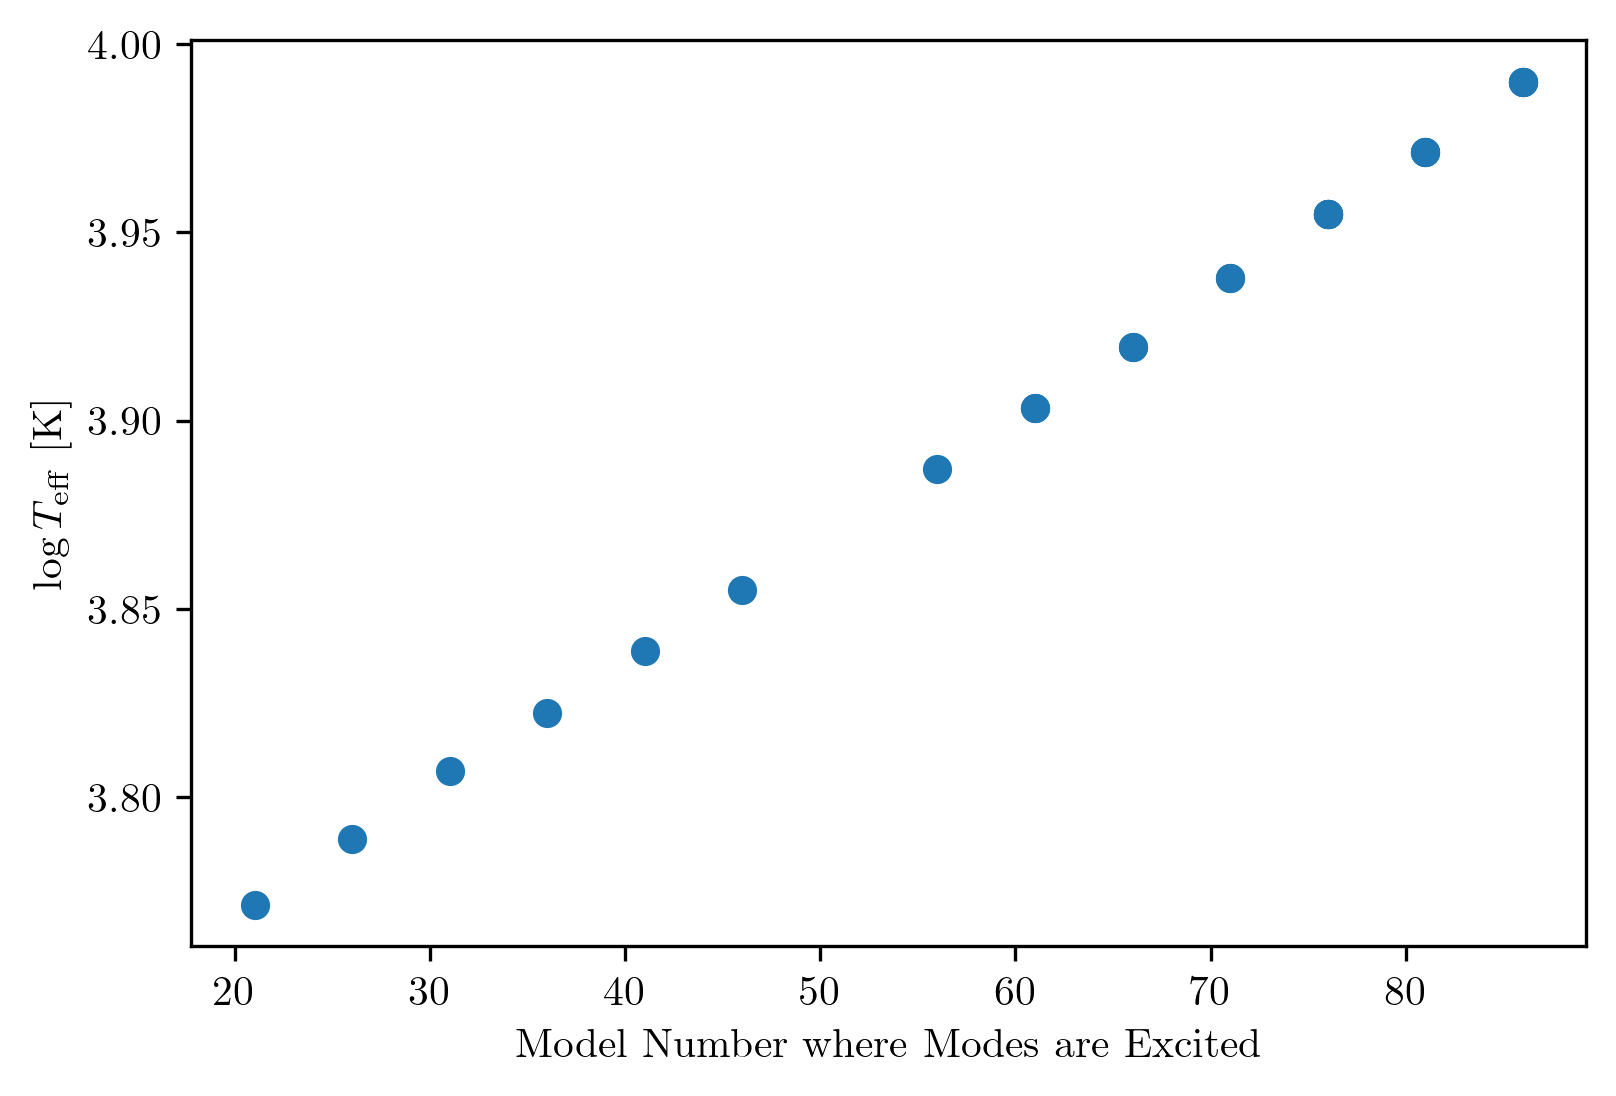

In [529]:
fig = plt.figure(dpi=300)
for d,df in all_excited.groupby('Directory'):
    plt.scatter(df['ProfileNumber'],df['Teff'])
plt.xlabel('Model Number where Modes are Excited')
plt.ylabel(r'$\log T_{\rm eff}$ [K]')


# The modes span a broad range of $n_g$, $n_p$, and $n_{pg}$ values

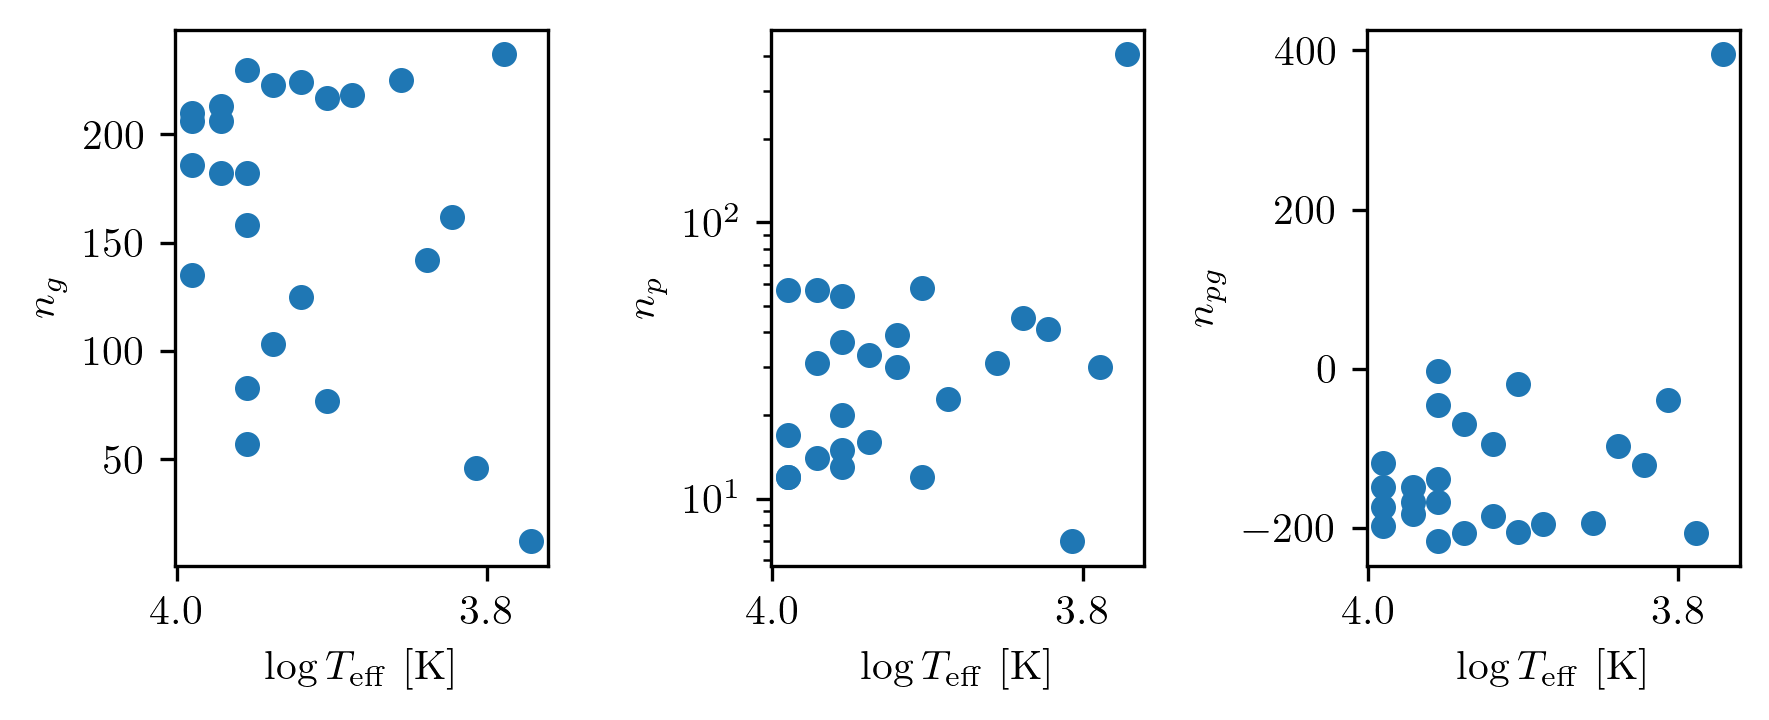

In [17]:
fig, ax = plt.subplots(1,3,dpi=300,sharex=True,figsize=(6,2.5))

for d,df in all_excited.groupby('Directory'):
    ax[0].plot(df['Teff'],df['n_g'],'o',ms=5)
    ax[1].semilogy(df['Teff'],df['n_p'],'o',ms=5) #log scale to see structure
    ax[2].plot(df['Teff'],df['n_pg'],'o',ms=5)


ax[0].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[0].set_ylabel('$n_g$')

ax[1].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[1].set_ylabel('$n_p$')

ax[2].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[2].set_ylabel('$n_{pg}$')

plt.gca().invert_xaxis()
fig.tight_layout()

#plt.savefig('mode_ids.pdf')

# And there's no clear pattern in how the frequencies evolve with effective temperature

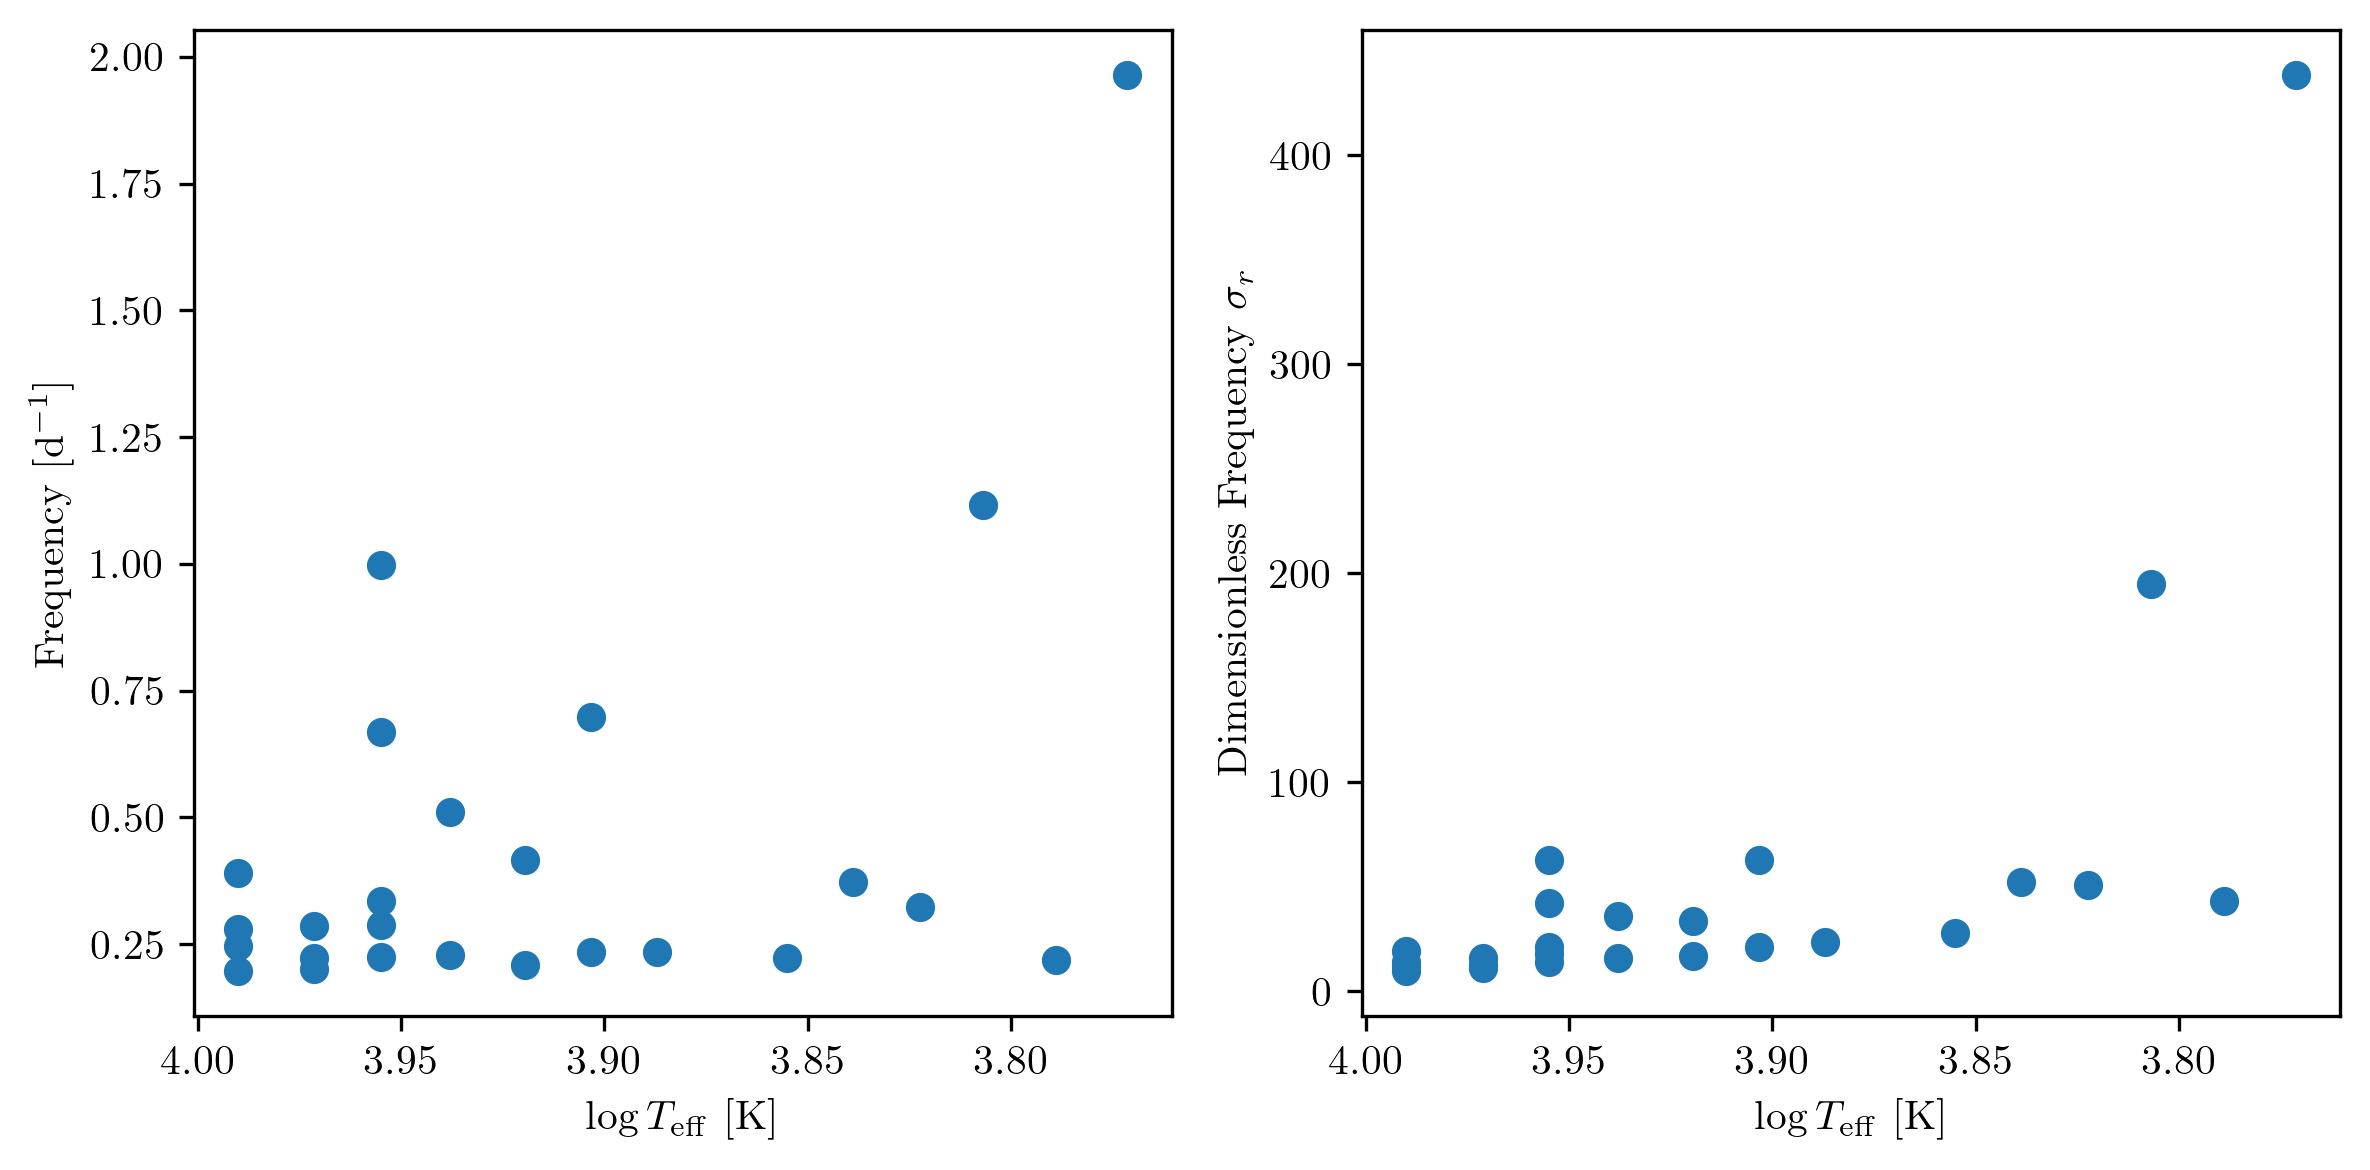

In [18]:
fig, ax = plt.subplots(1,2,dpi=300,sharex=True,figsize=(8,4))
for d,df in all_excited.groupby('Directory'):
    ax[0].scatter(df['Teff'],df['Freq'])
    ax[1].scatter(df['Teff'],df['OmegaR'])
    
ax[0].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[0].set_ylabel('Frequency [d$^{-1}$]')

ax[1].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[1].set_ylabel('Dimensionless Frequency $\sigma_r$')
plt.gca().invert_xaxis()
fig.tight_layout()

#plt.savefig('f_temp.pdf')

# And here's the inverse of the imaginary component of the frequency dimensionless ($1/\sigma_i$)

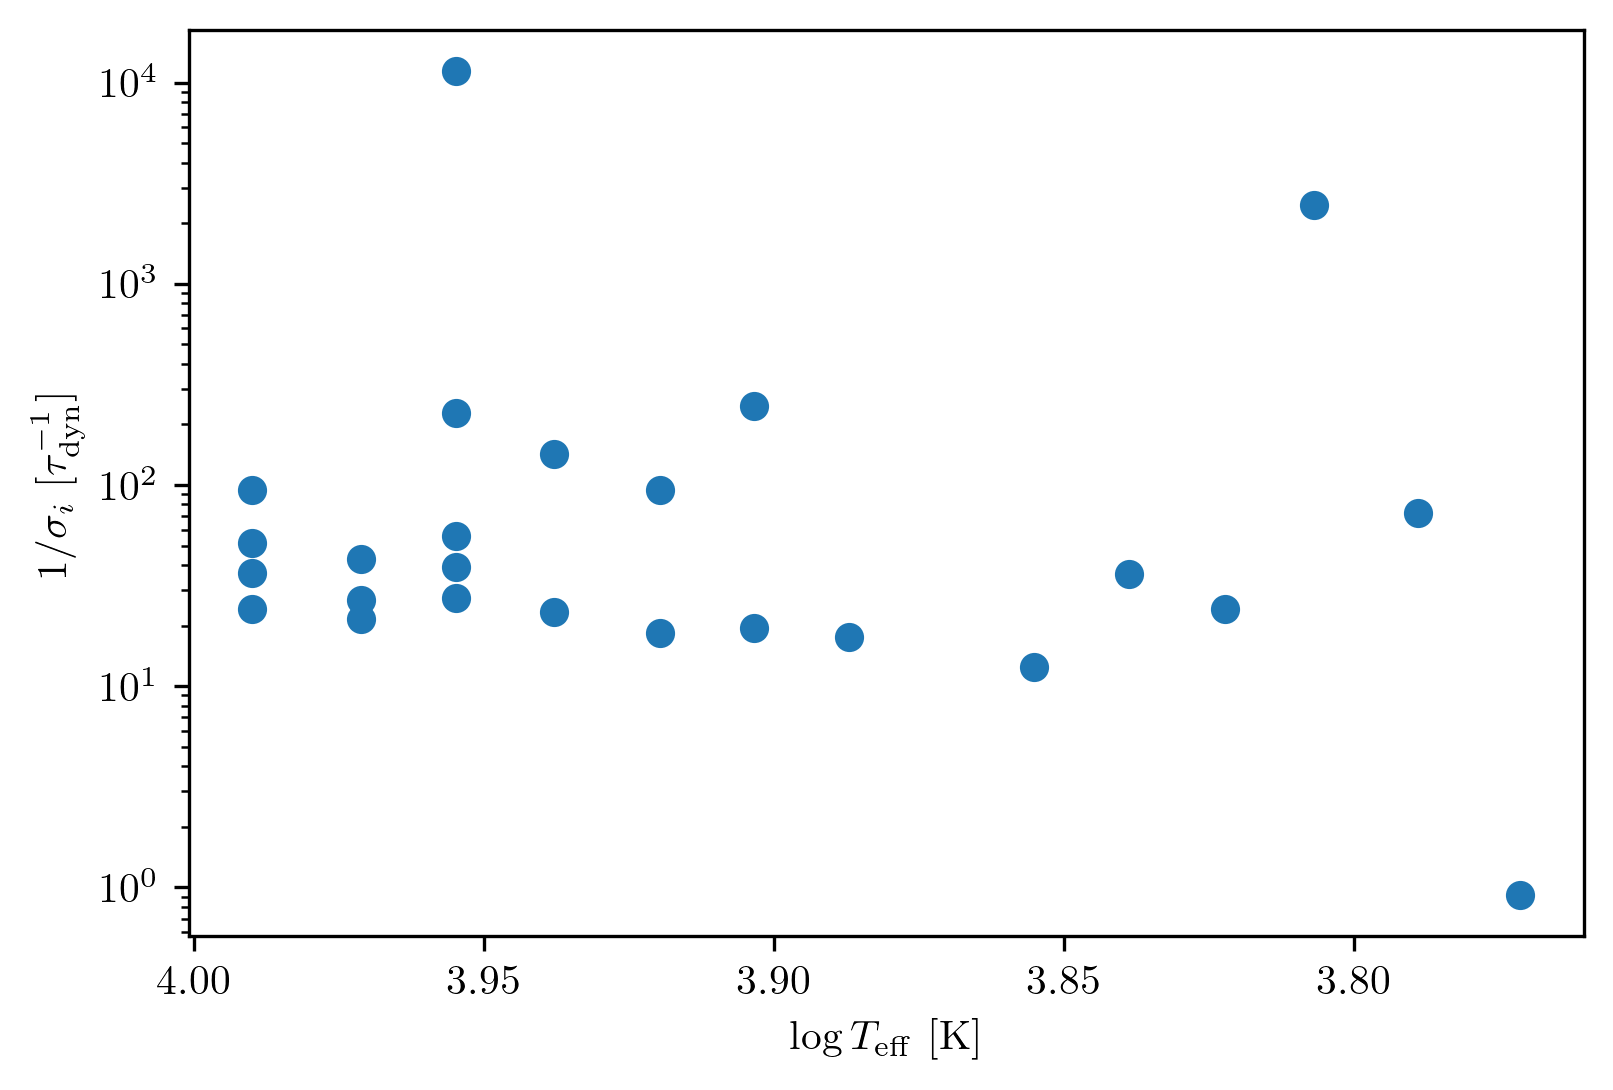

In [379]:
fig = plt.figure(dpi=300)
for d,df in all_excited.groupby('Directory'):
    plt.scatter(df['Teff'],1.0/df['OmegaI'])
plt.gca().invert_xaxis()
plt.xlabel(r'$\log T_{\rm eff}$ [K]')
plt.ylabel(r'$1/\sigma_i$ [$\tau_{\rm dyn}^{-1}$]')
plt.yscale('log')

# Now let's compare these frequencies to the dominant frequency observed in real FYPS, where we find qualitative agreement.

In [22]:
candidate_fyps = pd.read_csv('../../TESS/OutputFiles/candidate_fyps.csv',index_col=0)

In [24]:
import h5py as h5
import astropy.constants as c, astropy.units as u
filter_high_frequencies = True
filter_many_frequencies = True
KDE_res = 1000 #resolution of KDE


x_data_scatter = []
y_data_scatter = []
z_data_scatter = []
amp_data_scatter = []
tic_data_scatter = []
gal_data_scatter = []

for tic,cf in candidate_fyps.iterrows():
    with h5.File('../../TESS/OutputFiles/prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()]
        
    if ((good_fs[:,0].max() > 10.0)&filter_high_frequencies)|((len(good_fs)>=10)&filter_many_frequencies):
        continue
        
    if cf['Gal'] == 'LMC':
    
        x_data_scatter.append(cf['teff'])
        y_data_scatter.append(good_fs[0,0])
        amp_data_scatter.append(cf['highest_amp'])
        tic_data_scatter.append(tic)
        gal_data_scatter.append(cf['Gal'])

        lum_erg = (np.power(10.0,cf['lum'])*u.Lsun).to(u.erg/u.s)
        t_kelv = np.power(10.0,cf['teff'])*u.Kelvin
        sigma_T4 = c.sigma_sb * np.power(t_kelv, 4.0)
        r_2 = lum_erg / (4.0*np.pi*sigma_T4)
        rcm = np.sqrt(r_2).to(u.cm)
        M = 8.0*u.Msun # Instead of 15 for D-W+(2022)
        rho = (3*M / (4*np.pi*np.power(rcm,3.0))).to(u.gram / (u.cm)**3.0)
        tdyn = (1.0 / np.sqrt(c.G * rho)).to(u.day)

        z_data_scatter.append(good_fs[0,0]*tdyn/u.d)

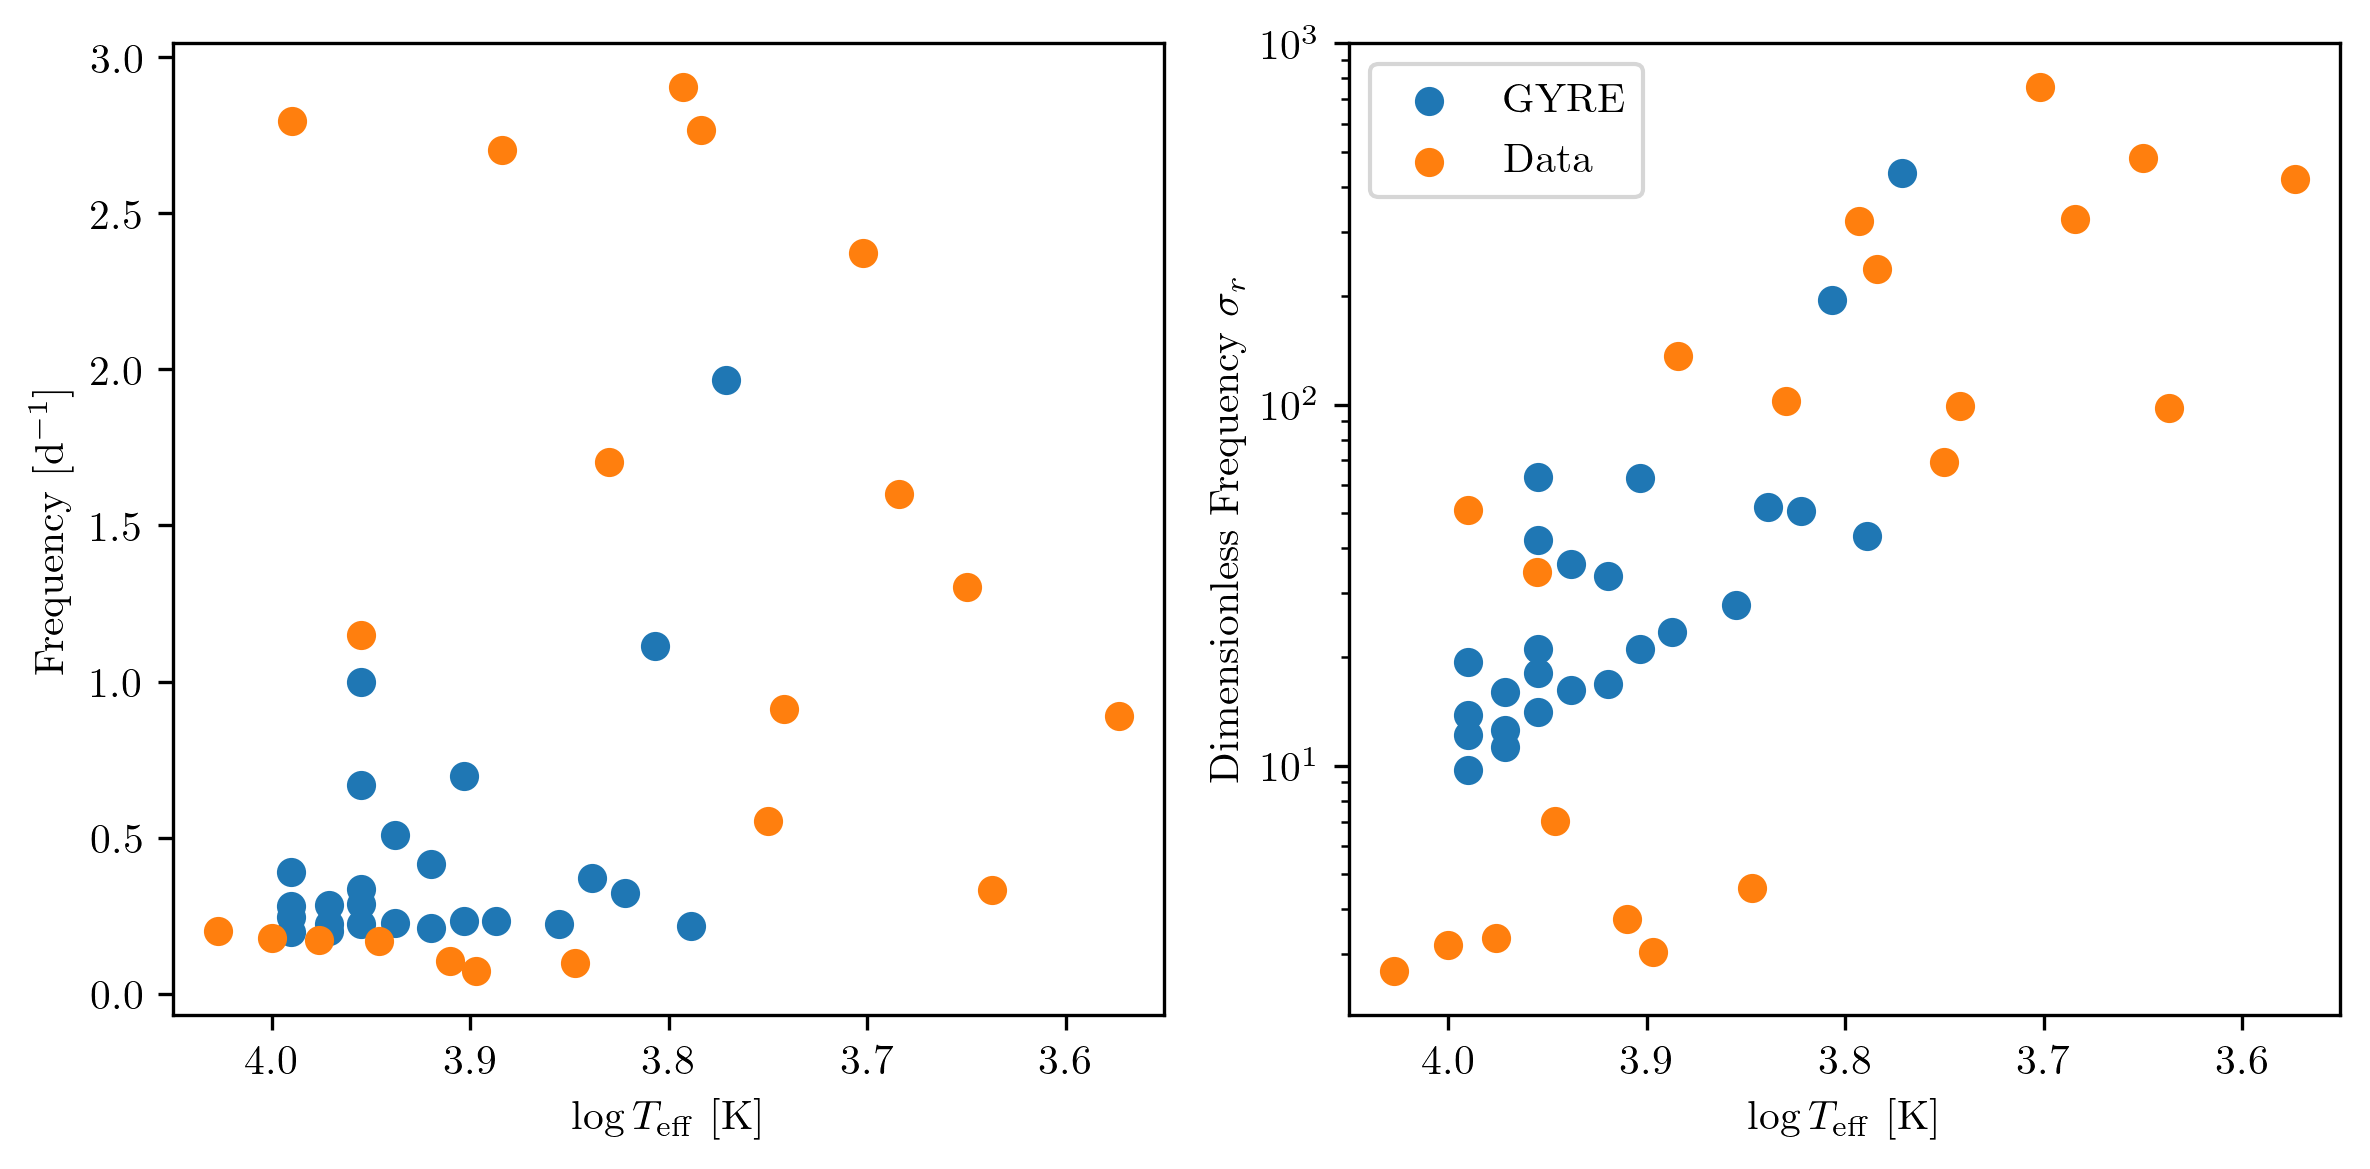

In [25]:
fig, ax = plt.subplots(1,2,dpi=300,sharex=True,figsize=(8,4))
for d,df in all_excited.groupby('Directory'):
    ax[0].scatter(df['Teff'],df['Freq'], label = 'GYRE')
    ax[1].scatter(df['Teff'],df['OmegaR'], label = 'GYRE')

ax[0].scatter(x_data_scatter,y_data_scatter, label = 'Data')
ax[1].scatter(x_data_scatter,z_data_scatter, label = 'Data')

ax[0].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[0].set_ylabel('Frequency [d$^{-1}$]')

ax[1].set_xlabel(r'$\log T_{\rm eff}$ [K]')
ax[1].set_ylabel('Dimensionless Frequency $\sigma_r$')
ax[1].set_yscale('log')
ax[1].legend()
plt.gca().invert_xaxis()
fig.tight_layout()

# Let's take a look at what's happening in some of these models. Let's look first at the one mode with a very high positive $n_{pg}$ value from the 21 $M_\odot$ model.

In [26]:
excited_21 = all_excited[(all_excited['Directory']=='./21M_Unno_Fneg/')]
high_npg = excited_21[(excited_21['n_pg']>200)]

In [27]:
def read_profile(profile_num = 1, logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    profile = pd.read_csv(logs+f'profile{profile_num}.data',sep='\\s+',skiprows=5)
    evo_stage = '_'.join(logs.split('/')[-2].split('_')[1:]).rstrip('/')
    profile['EvoStage'] = [evo_stage for i in range(len(profile))]
    profile['LOGS'] = [logs for i in range(len(profile))]

    return profile

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


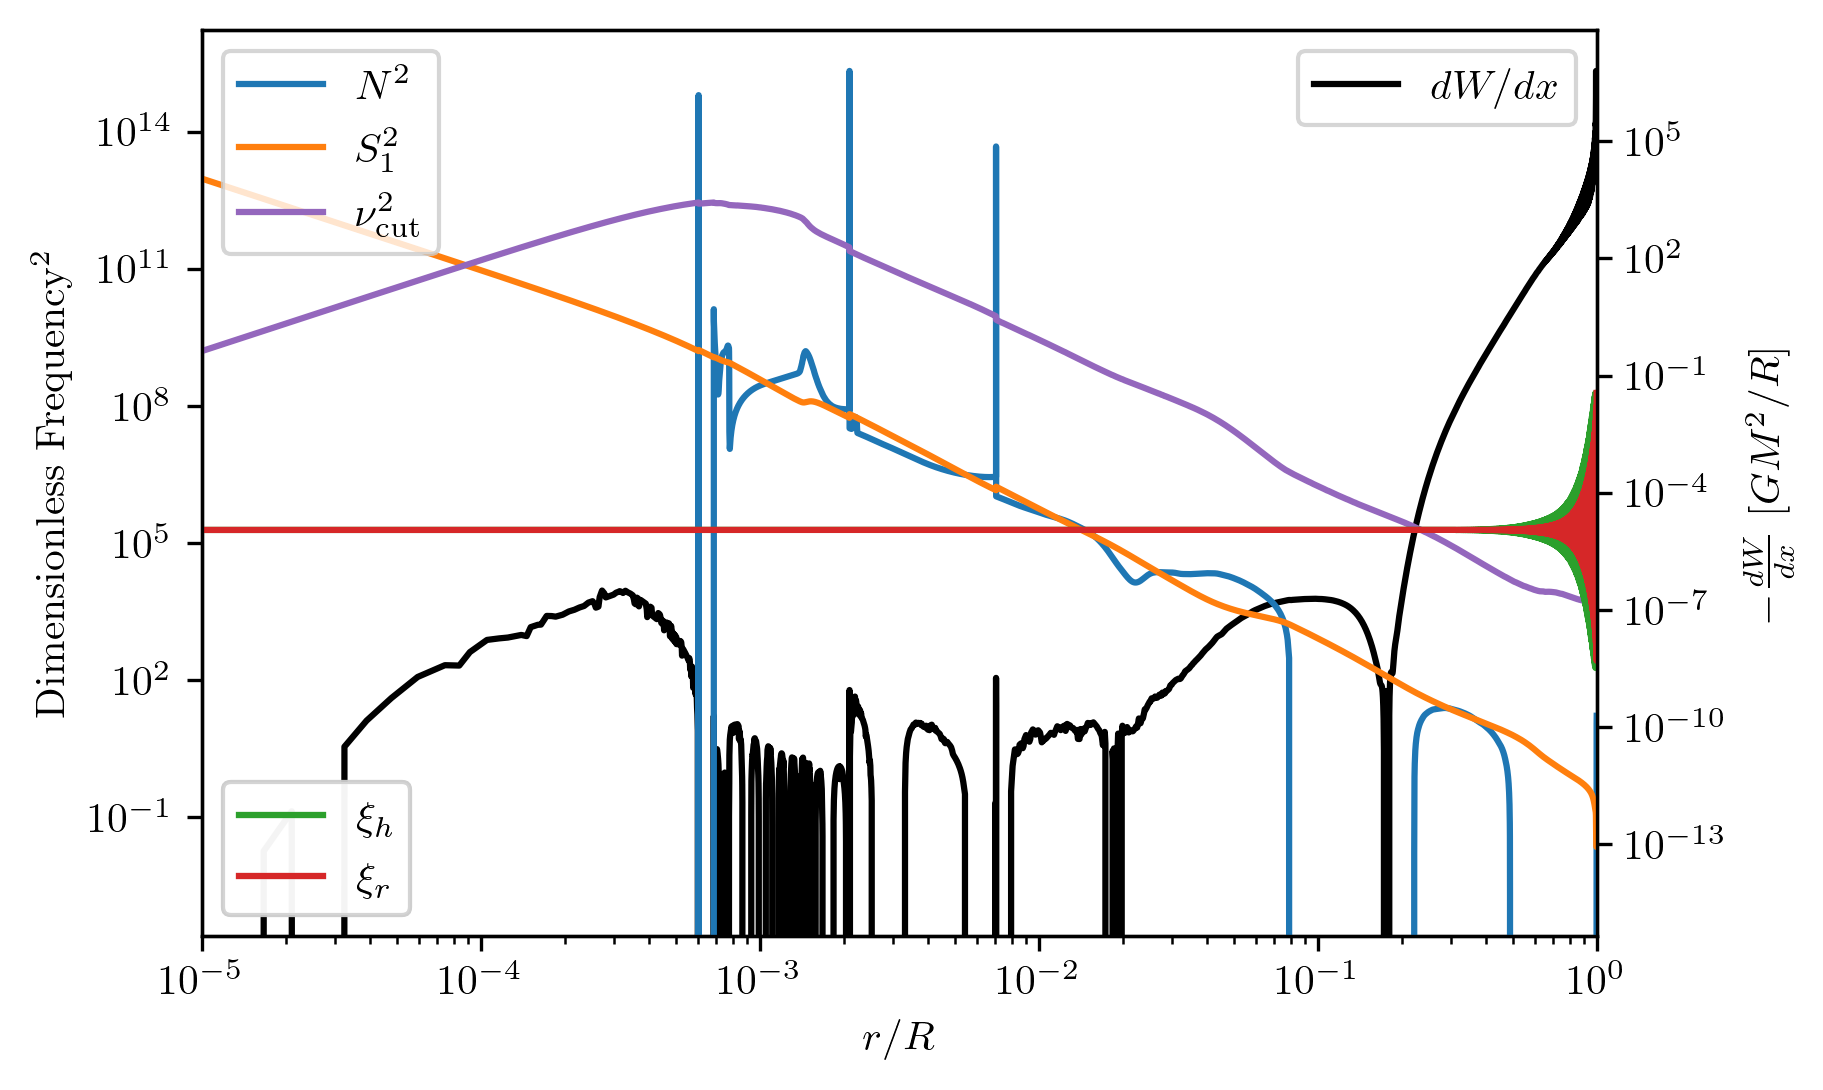

In [28]:
d = pg.read_output(f'{high_npg["Directory"].values[0]}detail_{high_npg["ProfileNumber"].values[0]}.l1.m+0.n{"+" if high_npg["n_pg"].values[0]>0 else "-"}{int(high_npg["n_pg"])}.h5')
x = d['x']
l = d.meta['l']
omega = d.meta['omega']

V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

profile = read_profile(profile_num = high_npg['ProfileNumber'].values[0], logs='../21M_mesa/LOGS_postrsg/')

H_p = (profile['pressure_scale_height'].values*u.Rsun).to(u.cm)
cs = profile['csound'].values * u.cm / u.s
nu_cutoff = (cs / (2.0*H_p)).to(1.0/u.day)
nu_cutoff_dim = (2*np.pi*nu_cutoff.to(u.Hz)*(high_npg['TauDyn'].values[0]*u.second)).decompose().value

fig = plt.figure(dpi=300)

plt.loglog(x, d['N2'], label=r'$N^2$')
plt.loglog(x, d['Sl2'], label=r'$S_1^2$')
plt.loglog(profile['radius']/profile['radius'].max(),nu_cutoff_dim**2.0,c='C4',label=r'$\nu_{\rm cut}^2$')
ax1 = plt.gca()

leg1 = plt.legend(loc='upper left')
ax1.add_artist(leg1)
ax1.set(xlabel='$r/R$',ylabel='Dimensionless Frequency$^2$',xlim=(1e-5,1))


#plt.axhline(omega.real**2, dashes=(4,2),label=None)
ax1.plot(x,omega.real**2*np.power(10.0,3*d['xi_h'].real/d['xi_h'].real.max()),label=r'$\xi_h$')
plt.plot(x,omega.real**2*np.power(10.0,3*d['xi_r'].real/d['xi_r'].real.max()),label=r'$\xi_r$')
handles, labels = plt.gca().get_legend_handles_labels()
leg2 = plt.legend(handles[3:],labels[3:],loc='lower left')
ax1.add_artist(leg2)



work_ax = plt.twinx(ax=ax1)
work_ax.loglog(x, -d['dW_dx'], scaley='symlog', c='k',label=r'$dW/dx$')
work_ax.legend(loc='upper right')
work_ax.set_ylabel(r'$-\frac{dW}{dx}$ [$GM^2/R$]')

ax1.set_zorder(work_ax.get_zorder()+1) 
ax1.patch.set_visible(False)

plt.axhline()

plt.savefig(f'propagation_21M_unno_prof{high_npg["ProfileNumber"].values[0]}.pdf', bbox_inches='tight')

# Here we're plotting the Brunt-Vaisaila frequency (blue), Lamb frequency (orange), and acoustic cutoff frequency (purple). All frequencies are dimensionless and squared. Green and red lines show the horizontal and radial displacement perturbations, and black shows the negative of the work integral $dW/dx$. Looks like this mode is mostly excited in the outer envelope; looks like a p-mode?

# Now let's do one with the lowest absolute $n_{pg}$ value (i.e., a mode that might have roughly even p- and g-mode characteristics)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


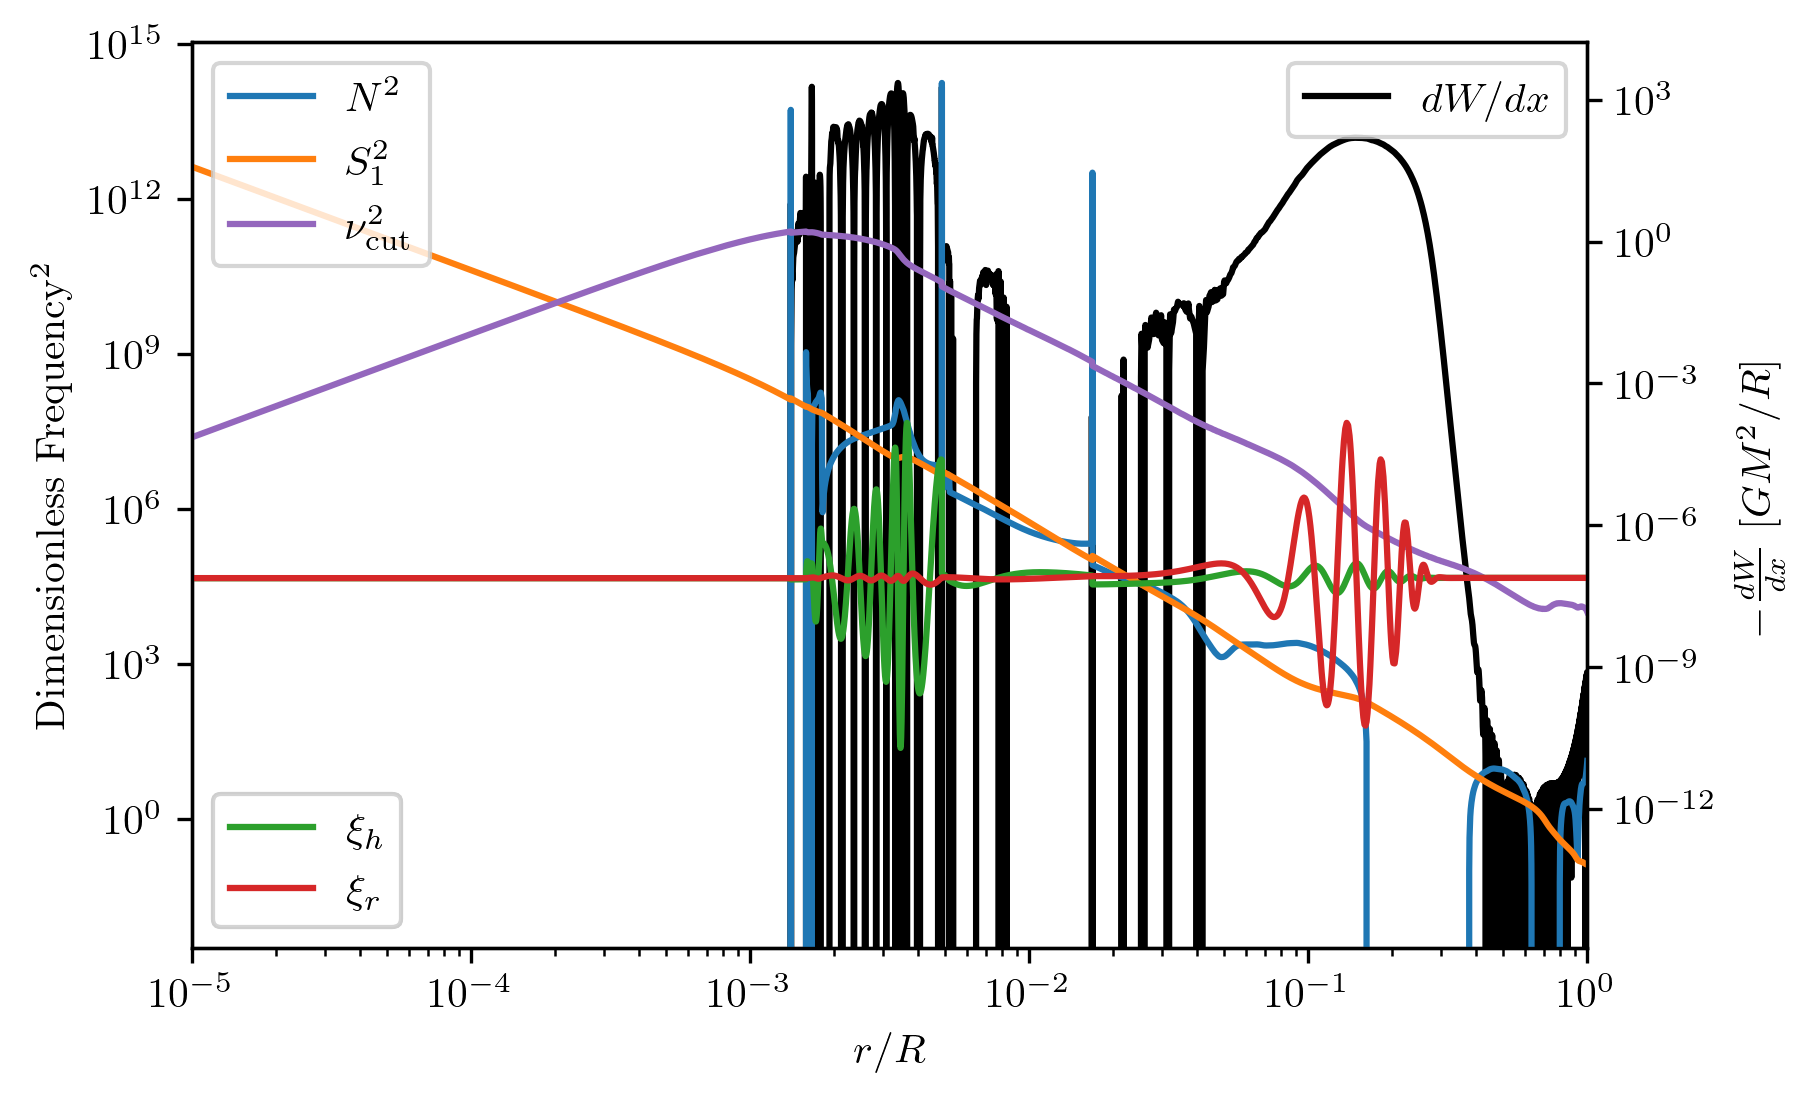

In [493]:
mid_npg = unno_excited.iloc[np.argmin(np.abs(unno_excited['n_pg']))]
d = pg.read_output(f'{mid_npg["Directory"]}detail_{mid_npg["ProfileNumber"]}.l1.m+0.n{"+" if mid_npg["n_pg"]>0 else ""}{int(mid_npg["n_pg"])}.h5')
x = d['x']
l = d.meta['l']
omega = d.meta['omega']

V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

profile = read_profile(profile_num = mid_npg['ProfileNumber'], logs='../21M_mesa/LOGS_postrsg/')

H_p = (profile['pressure_scale_height'].values*u.Rsun).to(u.cm)
cs = profile['csound'].values * u.cm / u.s
nu_cutoff = (cs / (2.0*H_p)).to(1.0/u.day)
nu_cutoff_dim = (2*np.pi*nu_cutoff.to(u.Hz)*(mid_npg['TauDyn']*u.second)).decompose().value

fig = plt.figure(dpi=300)

plt.loglog(x, d['N2'], label=r'$N^2$')
plt.loglog(x, d['Sl2'], label=r'$S_1^2$')
plt.loglog(profile['radius']/profile['radius'].max(),nu_cutoff_dim**2.0,c='C4',label=r'$\nu_{\rm cut}^2$')
ax1 = plt.gca()

leg1 = plt.legend(loc='upper left')
ax1.add_artist(leg1)
ax1.set(xlabel='$r/R$',ylabel='Dimensionless Frequency$^2$',xlim=(1e-5,1))


#plt.axhline(omega.real**2, dashes=(4,2),label=None)
ax1.plot(x,omega.real**2*np.power(10.0,3*d['xi_h'].real/d['xi_h'].real.max()),label=r'$\xi_h$')
plt.plot(x,omega.real**2*np.power(10.0,3*d['xi_r'].real/d['xi_r'].real.max()),label=r'$\xi_r$')
handles, labels = plt.gca().get_legend_handles_labels()
leg2 = plt.legend(handles[3:],labels[3:],loc='lower left')
ax1.add_artist(leg2)



work_ax = plt.twinx(ax=ax1)
work_ax.loglog(x, -d['dW_dx'], scaley='symlog', c='k',label=r'$dW/dx$')
work_ax.legend(loc='upper right')
work_ax.set_ylabel(r'$-\frac{dW}{dx}$ [$GM^2/R$]')

ax1.set_zorder(work_ax.get_zorder()+1) 
ax1.patch.set_visible(False)

plt.axhline()

plt.savefig(f'propagation_21M_unno_prof{mid_npg["ProfileNumber"]}.pdf', bbox_inches='tight')

# There are two locations where the work integral is high; the inner one looks like where the mode is g-mode-y (where the displacement $\xi$ is largely horizontal, and where $\omega^2 < N^2$ and $\omega < S_1^2$), and the outer one where the mode is p-mode-y  ($\xi$ is largely radial, and where $\omega^2 > S_1^2$ and $\omega > N^2$)

# Finally, let's look at one where the $n_{pg}$ value is strongly negative (e.g., profile 56):

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


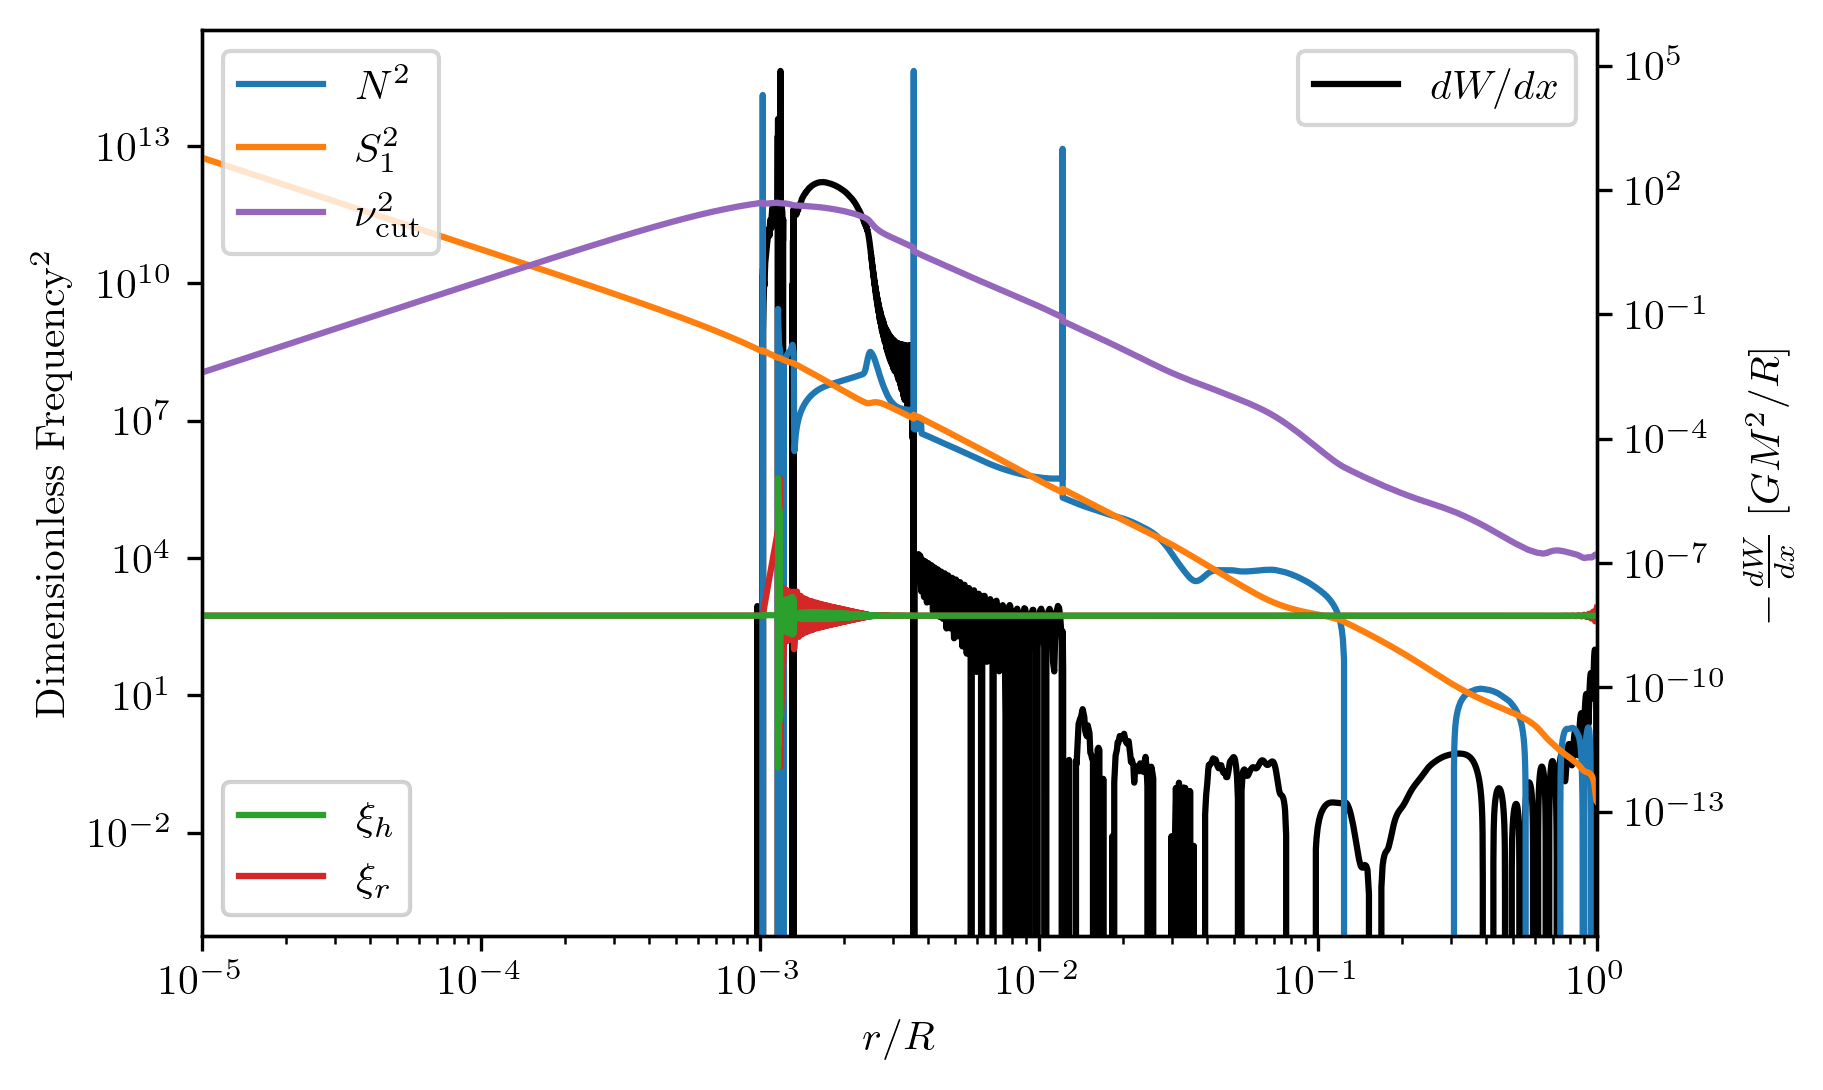

In [30]:
typical_num = 56
typ_npg = all_excited.loc[all_excited['ProfileNumber']==56]
d = pg.read_output(f'{typ_npg["Directory"].values[0]}detail_{typ_npg["ProfileNumber"].values[0]}.l1.m+0.n{"+" if typ_npg["n_pg"].values[0]>0 else ""}{int(typ_npg["n_pg"])}.h5')
x = d['x']
l = d.meta['l']
omega = d.meta['omega']

V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

profile = read_profile(profile_num = typ_npg['ProfileNumber'].values[0], logs='../21M_mesa/LOGS_postrsg/')

H_p = (profile['pressure_scale_height'].values*u.Rsun).to(u.cm)
cs = profile['csound'].values * u.cm / u.s
nu_cutoff = (cs / (2.0*H_p)).to(1.0/u.day)
nu_cutoff_dim = (2*np.pi*nu_cutoff.to(u.Hz)*(typ_npg['TauDyn'].values[0]*u.second)).decompose().value

fig = plt.figure(dpi=300)

plt.loglog(x, d['N2'], label=r'$N^2$')
plt.loglog(x, d['Sl2'], label=r'$S_1^2$')
plt.loglog(profile['radius']/profile['radius'].max(),nu_cutoff_dim**2.0,c='C4',label=r'$\nu_{\rm cut}^2$')
ax1 = plt.gca()

leg1 = plt.legend(loc='upper left')
ax1.add_artist(leg1)
ax1.set(xlabel='$r/R$',ylabel='Dimensionless Frequency$^2$',xlim=(1e-5,1))


#plt.axhline(omega.real**2, dashes=(4,2),label=None)
plt.plot(x,omega.real**2*np.power(10.0,3*d['xi_r'].real/d['xi_r'].real.max()),c='C3',label=r'$\xi_r$')


ax1.plot(x,omega.real**2*np.power(10.0,3*d['xi_h'].real/d['xi_h'].real.max()),c='C2',label=r'$\xi_h$')
handles, labels = plt.gca().get_legend_handles_labels()
leg2 = plt.legend(handles[3:][::-1],labels[3:][::-1],loc='lower left')
ax1.add_artist(leg2)



work_ax = plt.twinx(ax=ax1)
work_ax.loglog(x, -d['dW_dx'], scaley='symlog', c='k',label=r'$dW/dx$')
work_ax.legend(loc='upper right')
work_ax.set_ylabel(r'$-\frac{dW}{dx}$ [$GM^2/R$]')

ax1.set_zorder(work_ax.get_zorder()+1) 
ax1.patch.set_visible(False)

plt.axhline()

plt.savefig(f'propagation_21M_unno_prof{typ_npg["ProfileNumber"].values[0]}.pdf', bbox_inches='tight')

# This one looks like it's mostly happening right at the boundary of the convective core (ooo!), with a liiiiittle bit happening at the very outer layer.

# Old stuff from past runs; keeping code for useful plotting purposes

In [356]:
def read_profile(profile_num = 1, logs=''):
    if logs == '':
        raise OSError('Log directory does not exist')
    profile = pd.read_csv(logs+f'profile{profile_num}.data',sep='\\s+',skiprows=5)
    evo_stage = '_'.join(logs.split('/')[-2].split('_')[1:]).rstrip('/')
    profile['EvoStage'] = [evo_stage for i in range(len(profile))]
    profile['LOGS'] = [logs for i in range(len(profile))]

    return profile

In [183]:
import astropy.units as u
from astropy.constants import G as G_const
prof = read_profile(profile_num=75, logs=l_postrsg)
rad = (prof['radius'].values*u.Rsun).to(u.cm)
mass = (prof['mass'].values*u.Msun).to(u.g)
lum = (prof['luminosity'].values*u.Lsun).to(u.erg / u.s)
tdyn_prof = (np.sqrt((rad ** 3.0) / (2*G_const*mass))).to(u.day)
kh_prof = (G_const * (mass ** 2.0) / (rad*lum)).to(u.day)
kh_prof.to(u.day)

<Quantity [1.89442554e+04, 1.89442554e+04, 1.89442554e+04, ...,
           2.87325513e+01, 1.80984907e+01, 1.14006327e+01] d>

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in true_divide
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: divide by zero encountered in true_divide


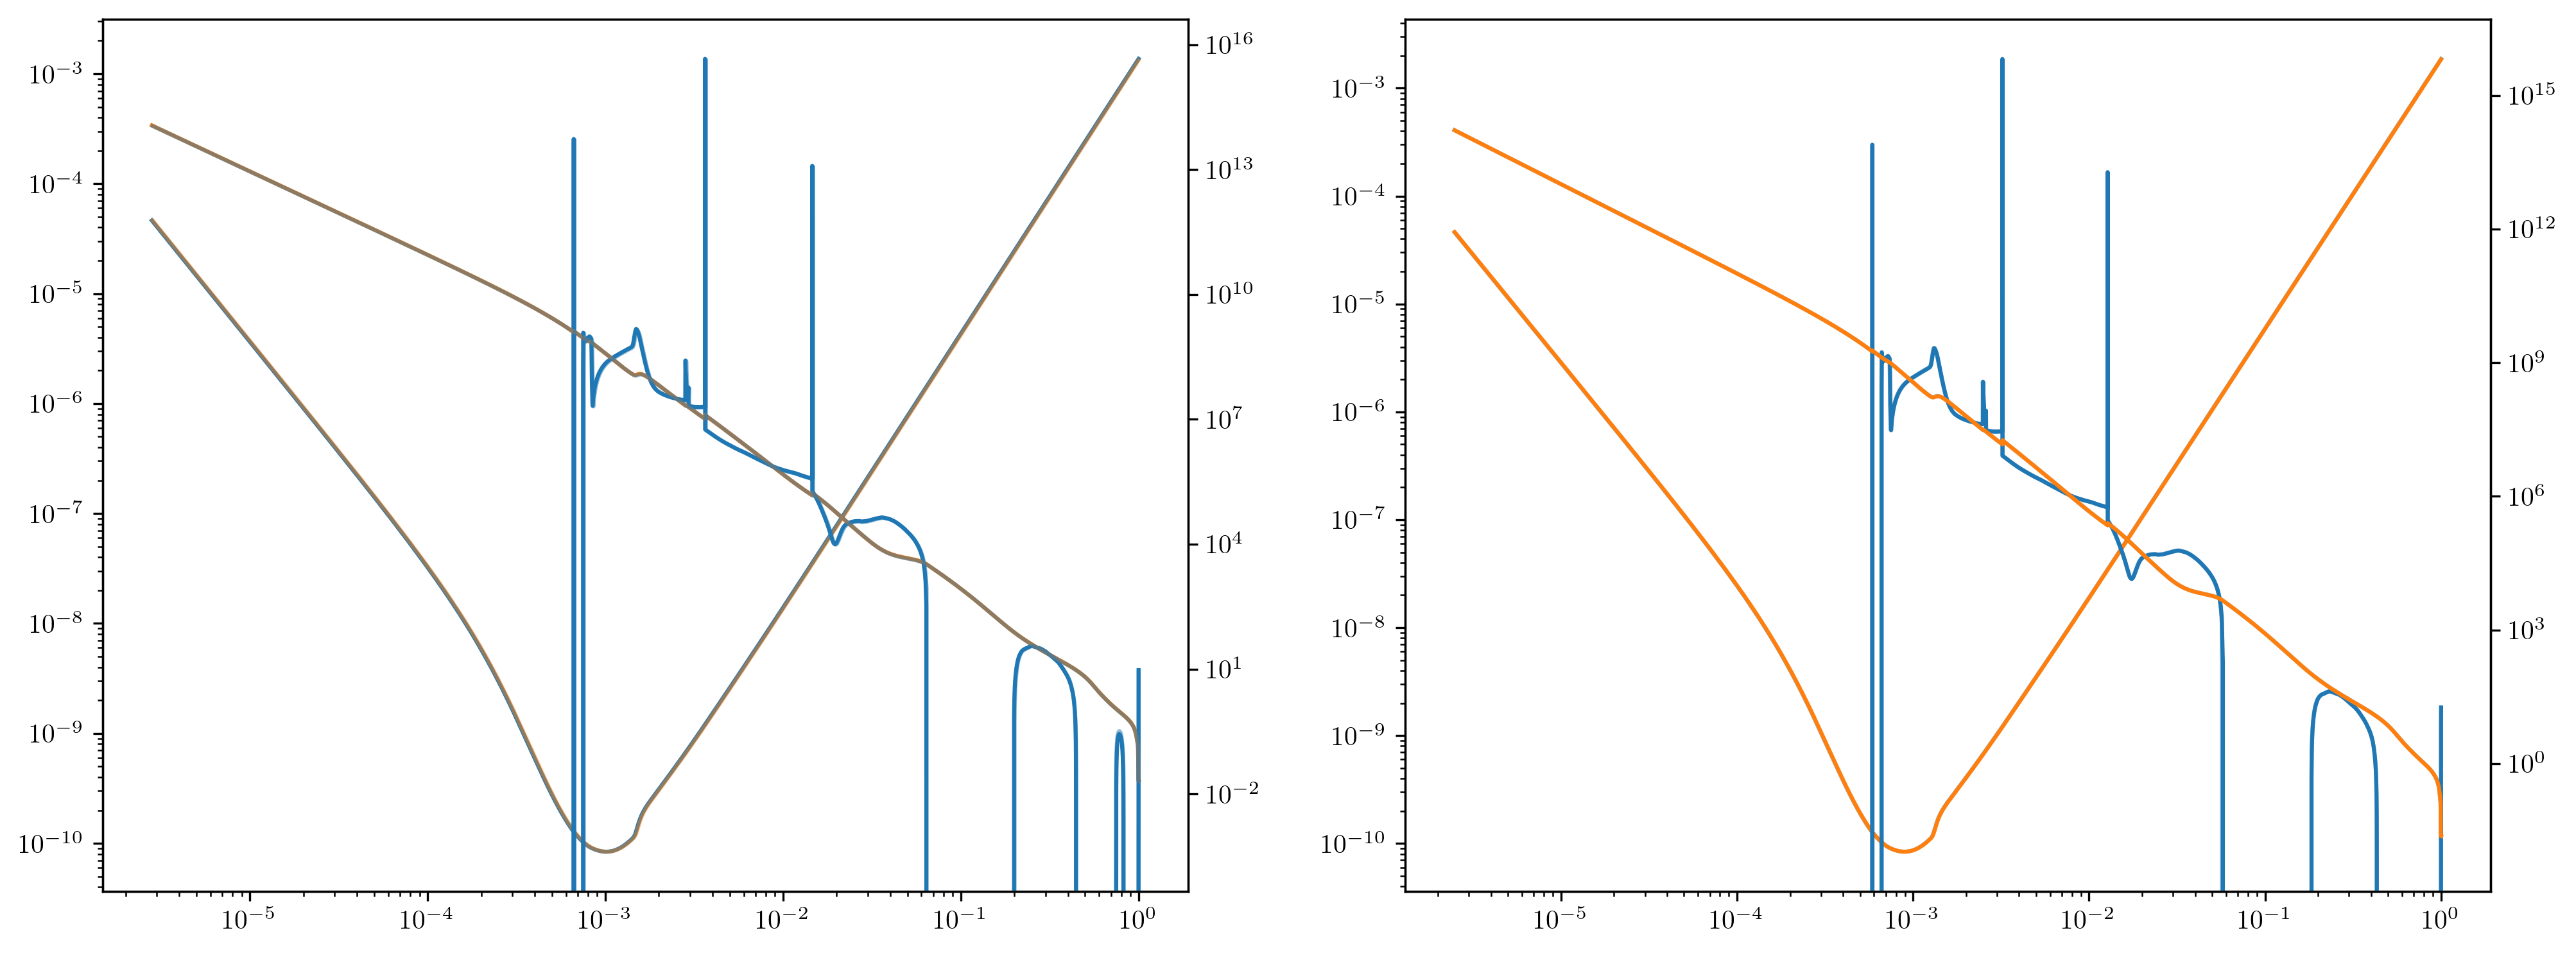

In [317]:
blues = [75,76]
reds = [52,53]

fig, ax = plt.subplots(1,2,figsize=(16,6),dpi=300)
blue_twax = ax[0].twinx()
for b in blues:
    prof = read_profile(profile_num=b, logs=l_postrsg)
    rad = (prof['radius'].values*u.Rsun).to(u.cm)
    mass = (prof['mass'].values*u.Msun).to(u.g)
    lum = (prof['luminosity'].values*u.Lsun).to(u.erg / u.s)
    tdyn_prof = (np.sqrt((rad ** 3.0) / (2*G_const*mass))).to(u.day)
    kh_prof = (G_const * (mass ** 2.0) / (rad*lum)).to(u.day)
    
    s = pg.read_output(f'summary_{b}.h5')
    if np.any(s['freq'].imag > 0):
        good = s[s['freq'].imag > 0]
        n_pg = good['n_pg'].data[0]
        d = pg.read_output(f'detail_{b}.l1.m+0.n{n_pg}.h5')
        x = d['x']
        ax[0].loglog(rad/rad.max(), tdyn_prof/kh_prof,alpha=1.0)
        
        V = d['V_2']*d['x']**2
        As = d['As']
        c_1 = d['c_1']
        Gamma_1 = d['Gamma_1']

        d['N2'] = d['As']/d['c_1']
        d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)
        blue_twax.loglog(d['x'], d['N2'], label='N^2')
        blue_twax.loglog(d['x'], d['Sl2'], label='S_l^2')
    else:
        good = s[np.argmin(np.abs(s['n_g']-12))]
        n_pg = good['n_pg']
        if n_pg >= 0:
            n_pg = '+'+str(n_pg)
        ax[0].loglog(rad/rad.max(), tdyn_prof/kh_prof,alpha=0.5)
        
        d = pg.read_output(f'detail_{b}.l1.m+0.n{n_pg}.h5')
        x = d['x']
        V = d['V_2']*d['x']**2
        As = d['As']
        c_1 = d['c_1']
        Gamma_1 = d['Gamma_1']

        d['N2'] = d['As']/d['c_1']
        d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)
        blue_twax.loglog(d['x'], d['N2'], c='C0',alpha=0.5)
        blue_twax.loglog(d['x'], d['Sl2'], c='C0',alpha=0.5)

red_twax = ax[1].twinx()
for r in reds:
    prof = read_profile(profile_num=r, logs=l_postrsg)
    rad = (prof['radius'].values*u.Rsun).to(u.cm)
    mass = (prof['mass'].values*u.Msun).to(u.g)
    lum = (prof['luminosity'].values*u.Lsun).to(u.erg / u.s)
    tdyn_prof = (np.sqrt((rad ** 3.0) / (2*G_const*mass))).to(u.day)
    kh_prof = (G_const * (mass ** 2.0) / (rad*lum)).to(u.day)
    
    s = pg.read_output(f'summary_{r}.h5')
    if np.any(s['freq'].imag > 0):
        good = s[s['freq'].imag > 0]
        n_pg = good['n_pg'].data[0]
        d = pg.read_output(f'detail_{r}.l1.m+0.n{n_pg}.h5')
        x = d['x']
        ax[1].loglog(rad/rad.max(), tdyn_prof/kh_prof,alpha=1.0)
        
        V = d['V_2']*d['x']**2
        As = d['As']
        c_1 = d['c_1']
        Gamma_1 = d['Gamma_1']

        d['N2'] = d['As']/d['c_1']
        d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)
        red_twax.loglog(d['x'], d['N2'], label='N^2')
        red_twax.loglog(d['x'], d['Sl2'], label='S_l^2')
    else:
        good = s[np.argmin(np.abs(s['n_g']-12))]
        n_pg = good['n_pg']
        if n_pg >= 0:
            n_pg = '+'+str(n_pg)
        d = pg.read_output(f'detail_{r}.l1.m+0.n{n_pg}.h5')
        x = d['x']
        ax[1].loglog(rad/rad.max(), tdyn_prof/kh_prof,alpha=0.5)
        
        V = d['V_2']*d['x']**2
        As = d['As']
        c_1 = d['c_1']
        Gamma_1 = d['Gamma_1']

        d['N2'] = d['As']/d['c_1']
        d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)
        red_twax.loglog(d['x'], d['N2'], c='C0',alpha=0.5)
        red_twax.loglog(d['x'], d['Sl2'], c='C0',alpha=0.5)

Text(0, 0.5, '$\\tau_{\\rm dyn}/\\tau_{\\rm KH}$')

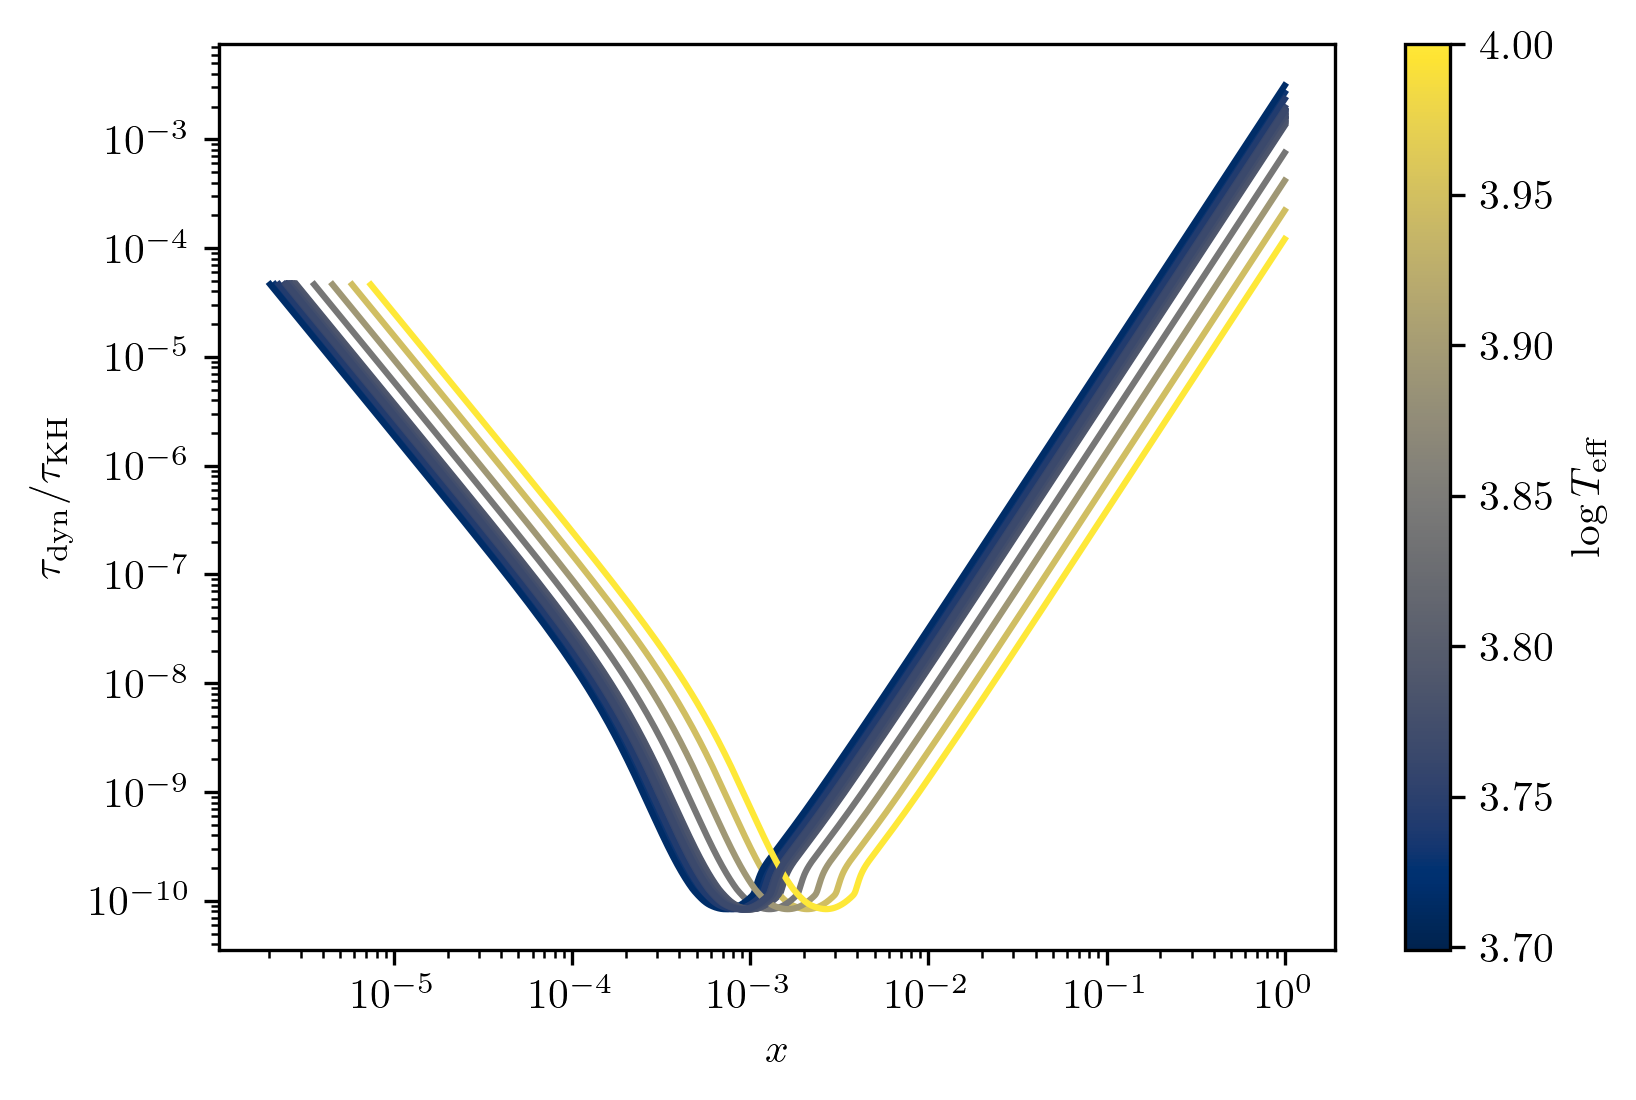

In [356]:
fig = plt.figure(dpi=300)

profs_ratios = []
ratio_mins = []
teff_min = np.log10(5000)
teff_max = 4.0

cmap = plt.get_cmap('cividis')

for summ in summaries:
    prof_num = summ.split('_')[1].split('.')[0]
    profs_ratios.append(int(prof_num))
    prof = read_profile(profile_num=int(prof_num), logs=l_postrsg)
    rad = (prof['radius'].values*u.Rsun).to(u.cm)
    mass = (prof['mass'].values*u.Msun).to(u.g)
    lum = (prof['luminosity'].values*u.Lsun).to(u.erg / u.s)
    
    tdyn_prof = (np.sqrt((rad ** 3.0) / (2*G_const*mass))).to(u.day)
    kh_prof = (G_const * (mass ** 2.0) / (rad*lum)).to(u.day)
    
    ratio = tdyn_prof/kh_prof
    ratio_mins.append(rad[np.argmin(ratio)]/rad.max())
    
    mod_num = all_index[(all_index['EvoStage']=='postrsg')&(all_index['profile_num']==int(prof_num))]['model_number'].values[0]
    this_hist = all_hist[all_hist['model_number']==mod_num]
    teff = this_hist['log_Teff'].values[0]
    color = (teff - teff_min) / (teff_max - teff_min)
    
    plt.loglog(rad/rad.max(),tdyn_prof/kh_prof,c=cmap(color))

import matplotlib.cm as cm
from matplotlib.colors import Normalize

norm = Normalize(vmin=teff_min,vmax=teff_max)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.colorbar(sm,label=r'$\log T_{\rm eff}$')
plt.xlabel('$x$')
plt.ylabel(r'$\tau_{\rm dyn}/\tau_{\rm KH}$')

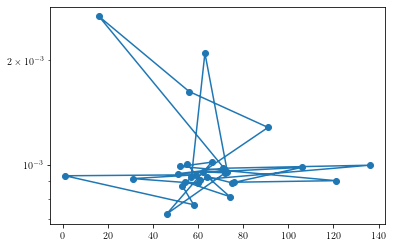

In [323]:
ratio_sort = np.argsort(profs_ratios)
ratio_mins = np.array(ratio_mins)[ratio_sort]
profs_rations = np.array(profs_ratios)[ratio_sort]
plt.semilogy(profs_ratios,ratio_mins,'-o')

In [263]:
np.unique(npg_good)

array([-13.,  -9.,  -7.,  -5.,  -3.,  -1.])

(3.825, 3.75)

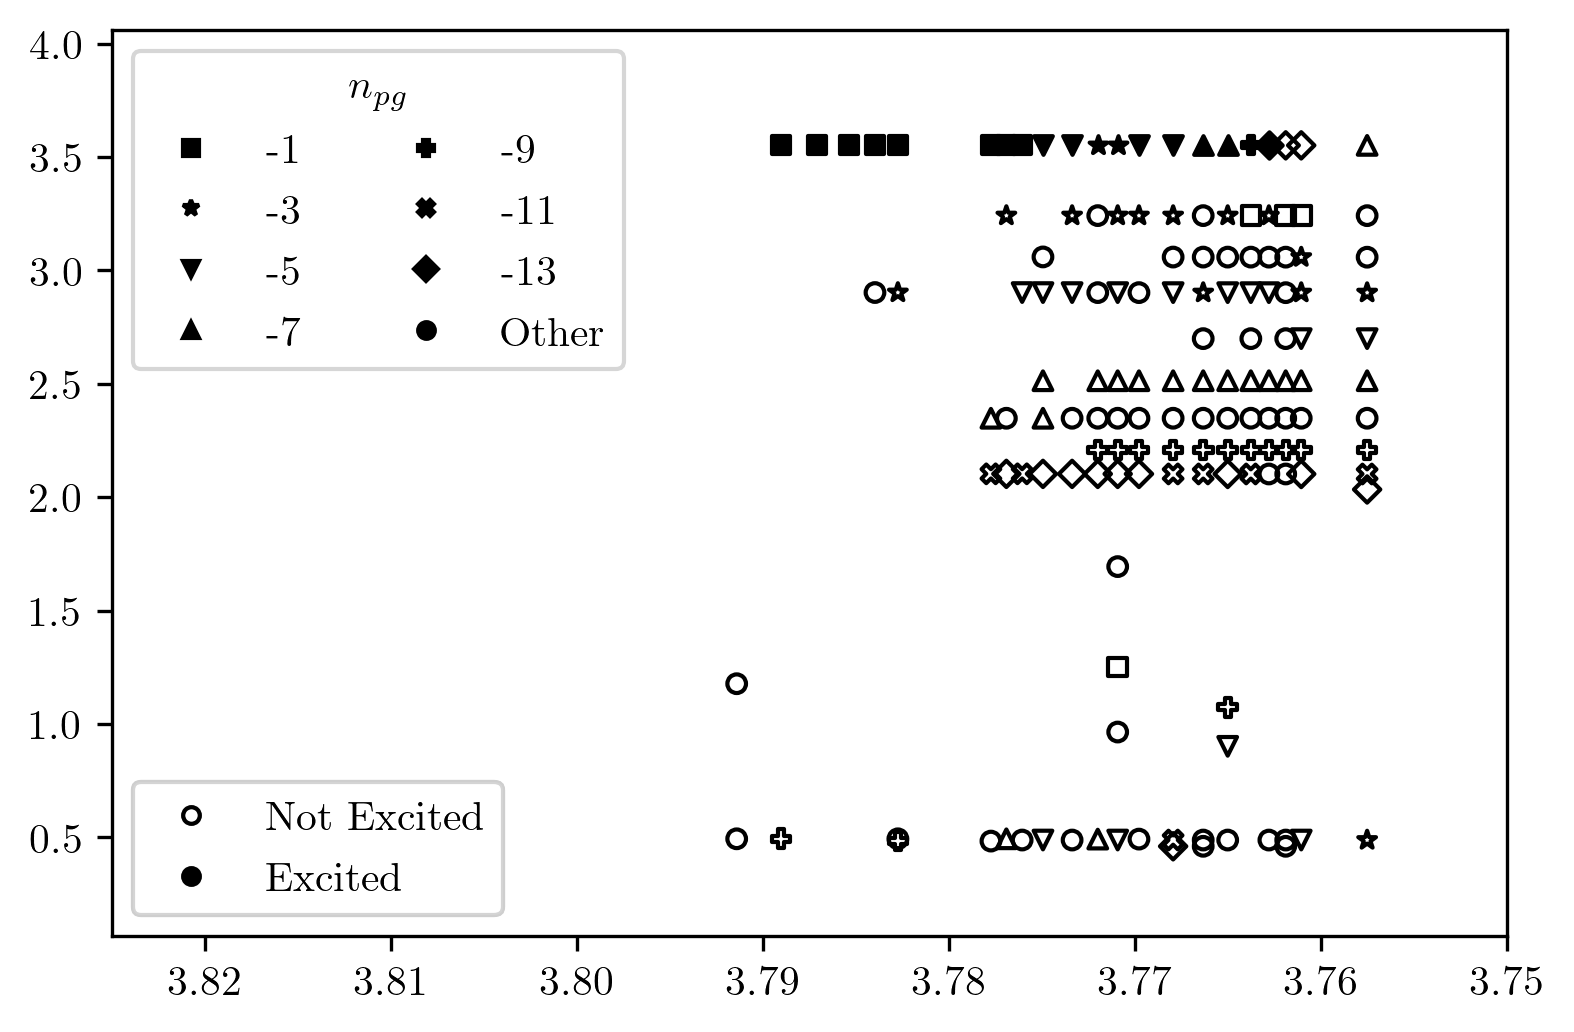

In [294]:
from matplotlib import lines as mlines

fig = plt.figure(dpi=300)
marker_dict = {-1:'s',-3:'*',-5:'v',-7:'^',-9:'P',-11:'X',-13:'D'}
for summ in summaries:
    prof_num = summ.split('_')[1].split('.')[0]
    
    mod_num = all_index[(all_index['EvoStage']=='postrsg')&(all_index['profile_num']==int(prof_num))]['model_number'].values[0]
    this_hist = all_hist[all_hist['model_number']==mod_num]
    teff = this_hist['log_Teff'].values[0]
    
    s = pg.read_output(summ)
    
    zooming_in = s[(s['n_pg'] < 0) & (s['n_pg'] > -14)]
    
    for i,z in zooming_in.to_pandas().iterrows():
        facecolor='None'
        if z['freq'].imag > 0:
            facecolor='k'
        marker = marker_dict.get(z['n_pg'],'o')
        plt.scatter(teff,z['freq'].real,c=facecolor,s=20,edgecolor='k',marker=marker)


handles = []
for k, v in marker_dict.items():
    handle =  mlines.Line2D([], [], color='k', marker=v,
                          markersize=4, lw=0, label=k)
    handles.append(handle)
handles.append(mlines.Line2D([], [], color='k', marker='o',
                          markersize=4, lw=0, label='Other'))
leg1 = plt.legend(loc='upper left',handles=handles,ncol=2,title=r'$n_{pg}$')
plt.gca().add_artist(leg1)

handles = []
for fc,lab in zip(['None','k'],['Not Excited','Excited']):
    handle =  mlines.Line2D([], [], markerfacecolor=fc, markeredgecolor='k', marker='o',
                          markersize=4, lw=0, label=lab)
    handles.append(handle)
leg2 = plt.legend(loc='lower left',handles=handles)
plt.gca().add_artist(leg2)

plt.gca().invert_xaxis()
plt.xlim(3.825,3.75)

In [2]:
s = pg.read_output('summary.h5')

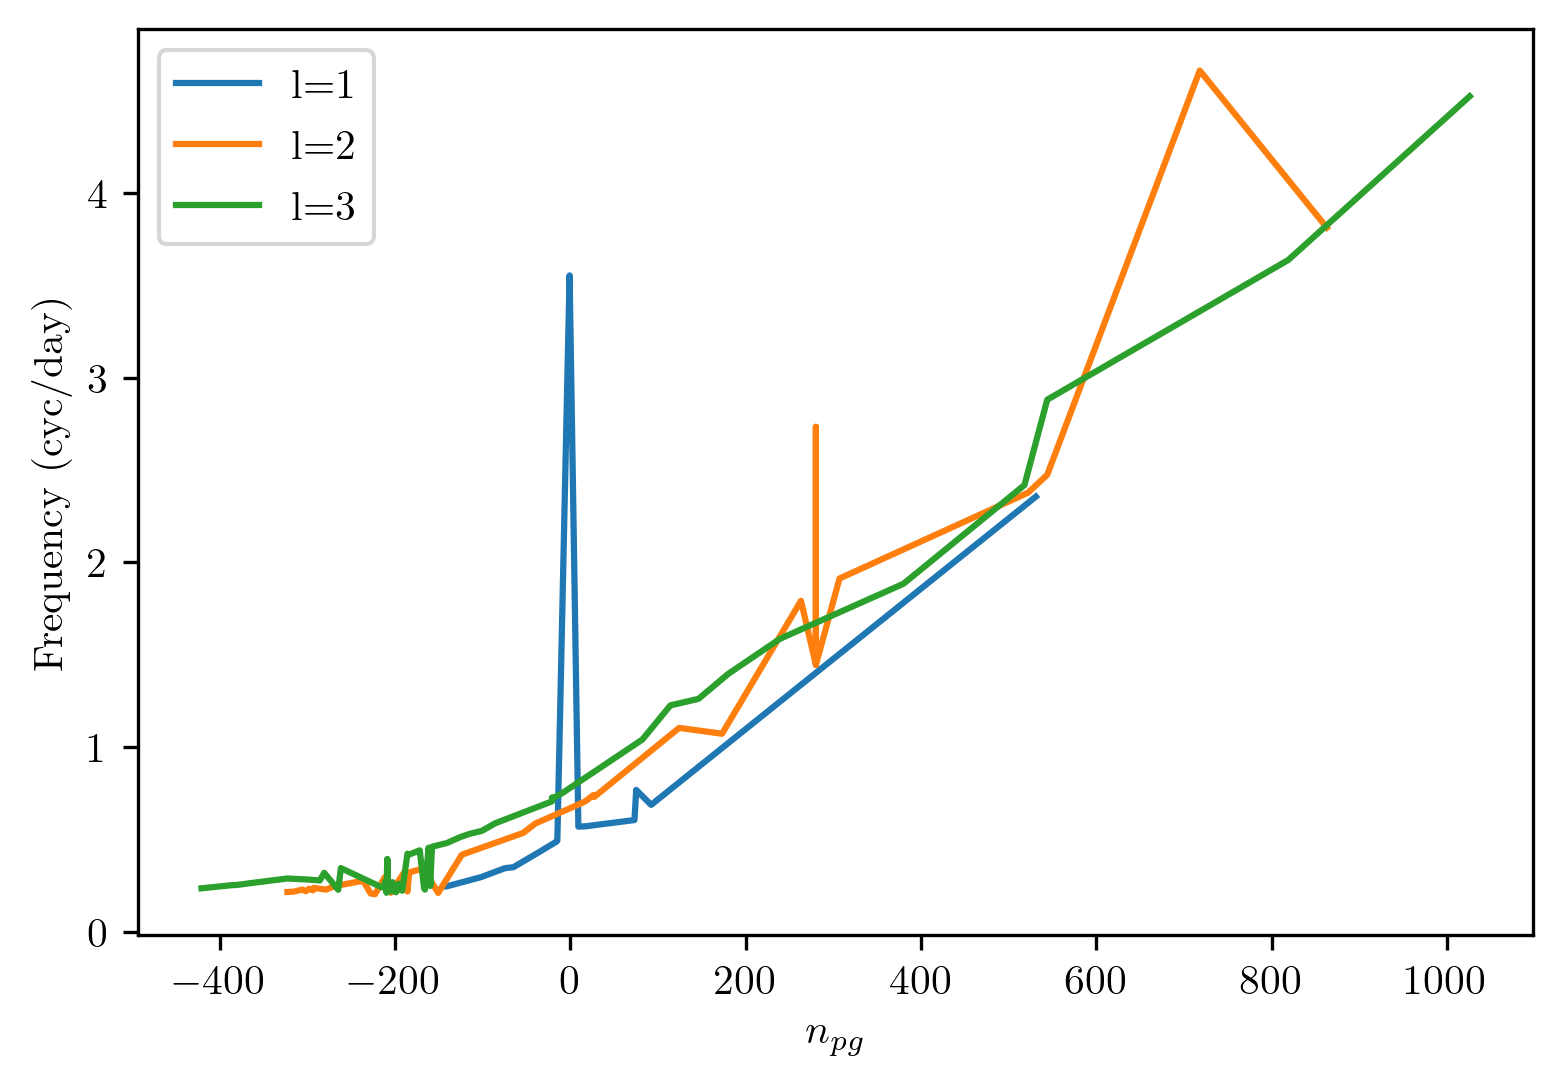

In [14]:
plt.figure(dpi=300)

sg = s.group_by('l')

for gr in sg.groups:
    n_sort = np.argsort(gr['n_pg'])
    plt.plot(gr['n_pg'][n_sort], gr['freq'].real[n_sort], label=fr'l={np.unique(gr["l"].data)[0]}',rasterized=True)

plt.xlabel('$n_{pg}$')
plt.ylabel('Frequency (cyc/day)')
plt.legend()

No handles with labels found to put in legend.


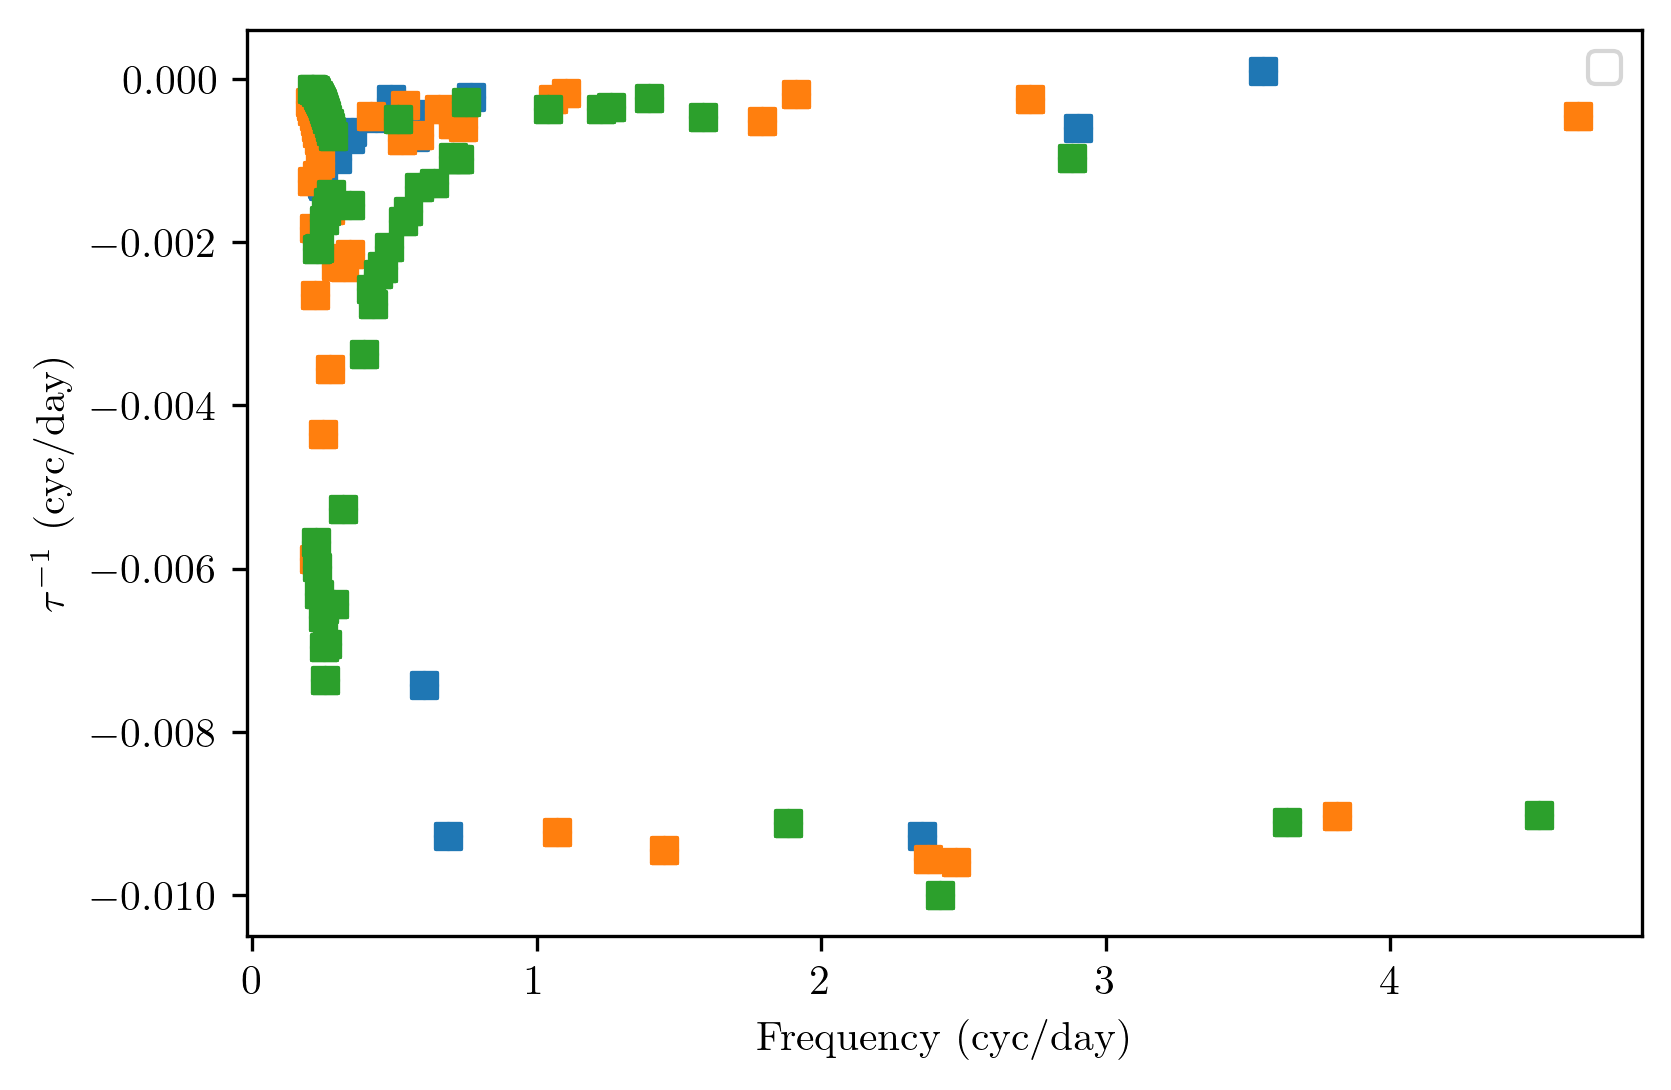

In [24]:
plt.figure(dpi=300)

sg = s.group_by('l')
markers = ['o','s','^','+']

for gr in sg.groups:
    grm = gr.group_by('m')
    l = np.unique(gr["l"].data)[0]
    for mgr in grm:
        m = np.unique(mgr["m"].data)[0]
        plt.scatter(mgr['freq'].real, mgr['freq'].imag,c=f'C{l-1}',marker=markers[np.abs(m)],rasterized=True)

plt.xlabel('Frequency (cyc/day)')
plt.ylabel(r'$\tau^{-1}$ (cyc/day)')
plt.legend()

In [26]:
excited_modes = s[s['freq'].imag > 0.0]
excited_modes

E_norm,freq,l,m,n_g,n_p,n_pg,omega
float64,complex128,int32,int32,int32,int32,int32,complex128
7051546770271.509,(3.5525169003563457+9.771567396634041e-05j),1,-1,12,11,-1,(847.2313014625623+0.02330397854532085j)
7051546770271.509,(3.5525169003563457+9.771567396634041e-05j),1,0,12,11,-1,(847.2313014625623+0.02330397854532085j)
7051546770271.509,(3.5525169003563457+9.771567396634041e-05j),1,1,12,11,-1,(847.2313014625623+0.02330397854532085j)


In [4]:
sg

E_norm,freq,l,m,n_g,n_p,n_pg,omega
float64,complex128,int32,int32,int32,int32,int32,complex128
115.63946299707521,(0.2469938802016529-0.0012194217429272922j),1,-1,189,48,-141,(58.9049827055134-0.290816989551381j)
154.58035581889095,(0.2484221583913313-0.0013082718745053817j),1,-1,190,46,-144,(59.24560937202424-0.31200664599030575j)
40.24502087565908,(0.24564546399662485-0.0012866310681488794j),1,-1,189,46,-143,(58.583402133670226-0.30684558158206054j)
1145.3265621389016,(0.29660873908390945-0.000986188153218269j),1,-1,159,57,-102,(70.73751232936378-0.2351936657793985j)
139.7704424311047,(0.34460340380432597-0.0007394113110243542j),1,-1,139,64,-75,(82.1836457032146-0.17634044395185422j)
6122.3438326770065,(0.3507031118564835-0.0006454380328133949j),1,-1,132,67,-65,(83.63835056079112-0.15392898046426653j)
1631.1415595435246,(0.43434350210407086-0.0004824524019211681j),1,-1,115,80,-35,(103.58554818768825-0.11505892521789543j)
2051.3707780841014,(0.4886937334140221-0.00025110676491815097j),1,-1,104,88,-16,(116.54740551281523-0.059885854793912084j)
62.50751292623029,(0.49408510689831187-0.00033823610461057943j),1,-1,104,89,-15,(117.83318134496044-0.08066512367108061j)


In [11]:
s['n_pg'][np.argmin(np.abs(s['freq'].real - 2.76524428))]
s['l','n_pg'][np.argmin(np.abs(s['freq'].real - 2.76524428))]

l,n_pg
int32,int32
1,241


In [31]:
d = pg.read_output('detail.l1.m-1.n-1.h5')

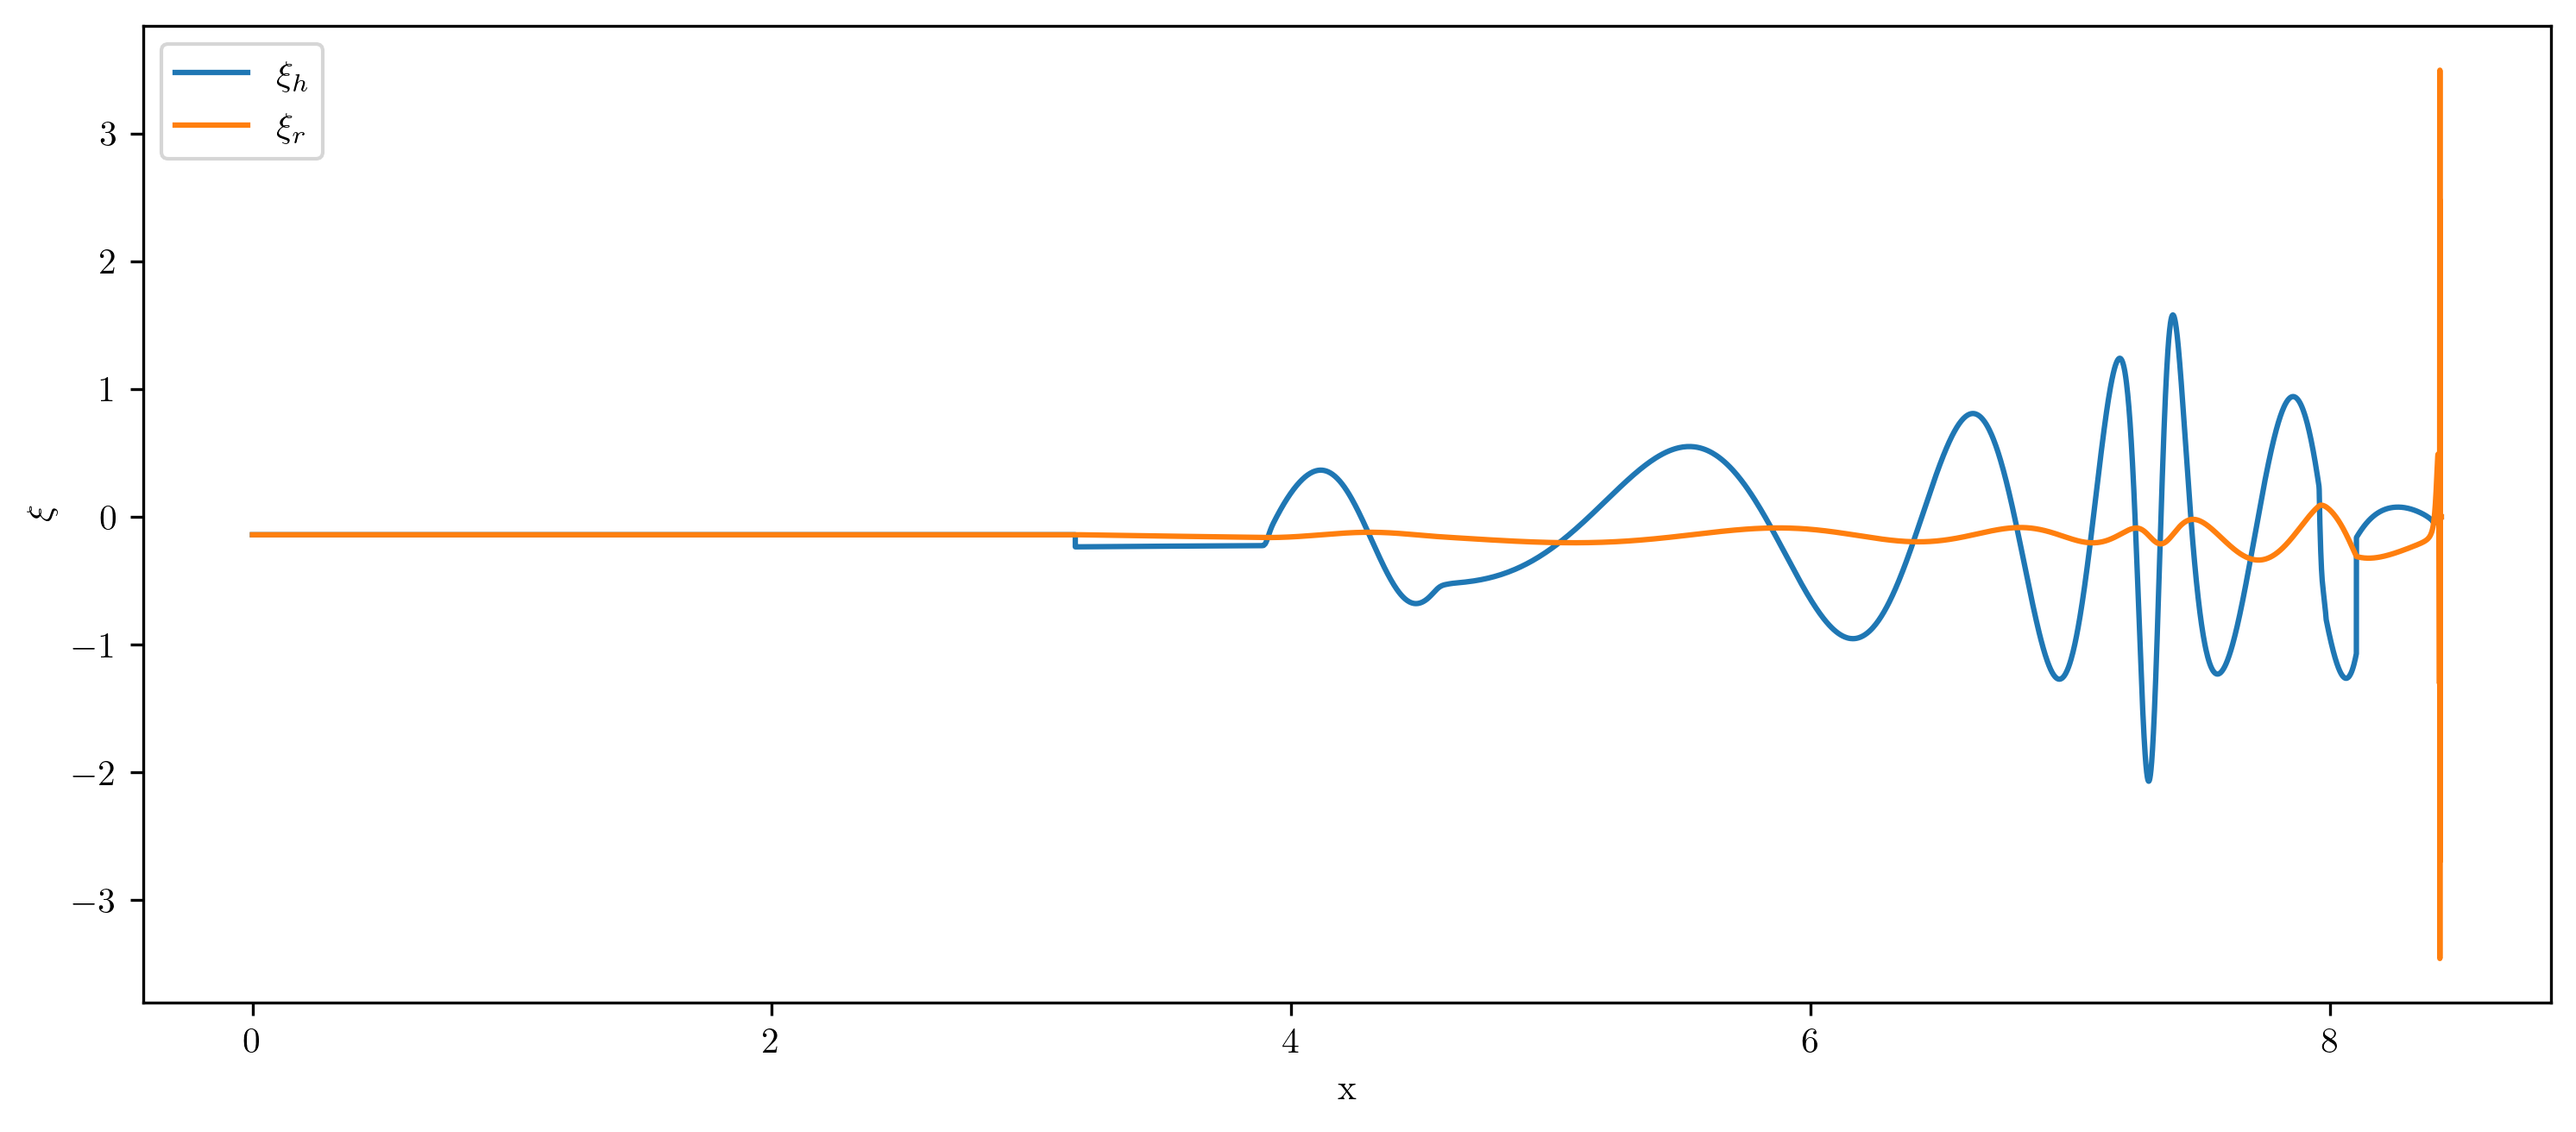

In [32]:
import astropy.units as u
plt.figure(figsize=(12,5),dpi=300)

plt.plot((d['M_r']*u.gram).to(u.Msun), d['xi_h'].real, label=r'$\xi_h$',rasterized=True)
plt.plot((d['M_r']*u.gram).to(u.Msun), d['xi_r'].real, label=r'$\xi_r$',rasterized=True)



plt.xlabel('x')
plt.ylabel(r'$\xi$')
#plt.xlim(0.001,0.003)
#plt.ylim(-2,2)

plt.legend()

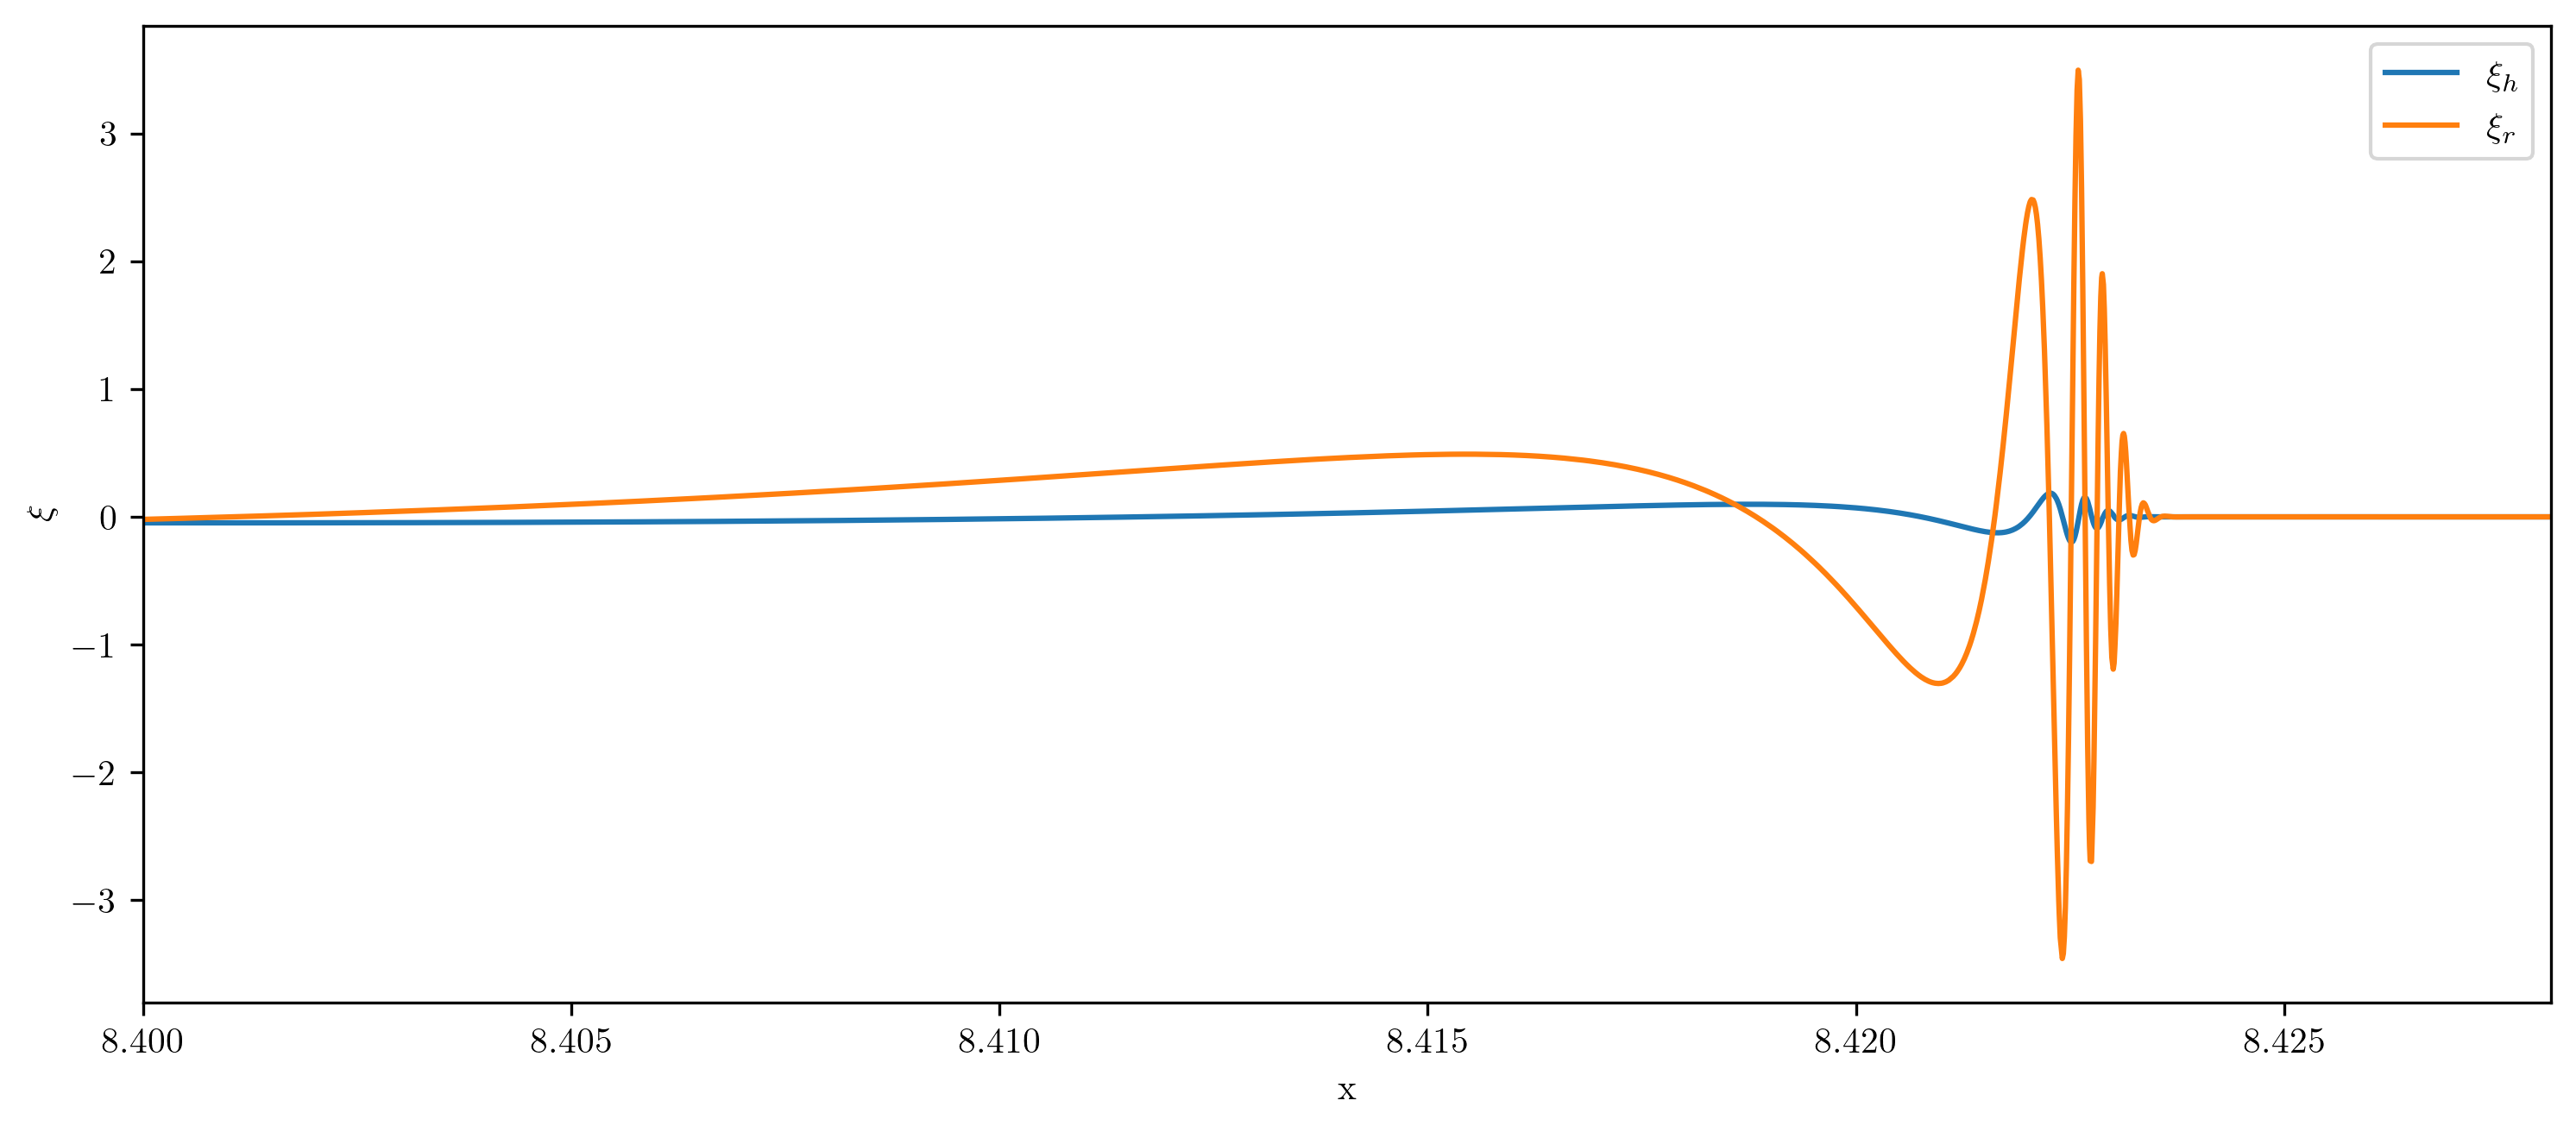

In [33]:
import astropy.units as u
plt.figure(figsize=(12,5),dpi=300)

plt.plot((d['M_r']*u.gram).to(u.Msun), d['xi_h'].real, label=r'$\xi_h$',rasterized=True)
plt.plot((d['M_r']*u.gram).to(u.Msun), d['xi_r'].real, label=r'$\xi_r$',rasterized=True)


plt.xlabel('x')
plt.ylabel(r'$\xi$')
plt.xlim(8.4,(d['M_r']*u.gram).to(u.Msun).value.max())
#plt.ylim(-2,2)

plt.legend()

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


(847.2313014625623+0.02330397854532085j)


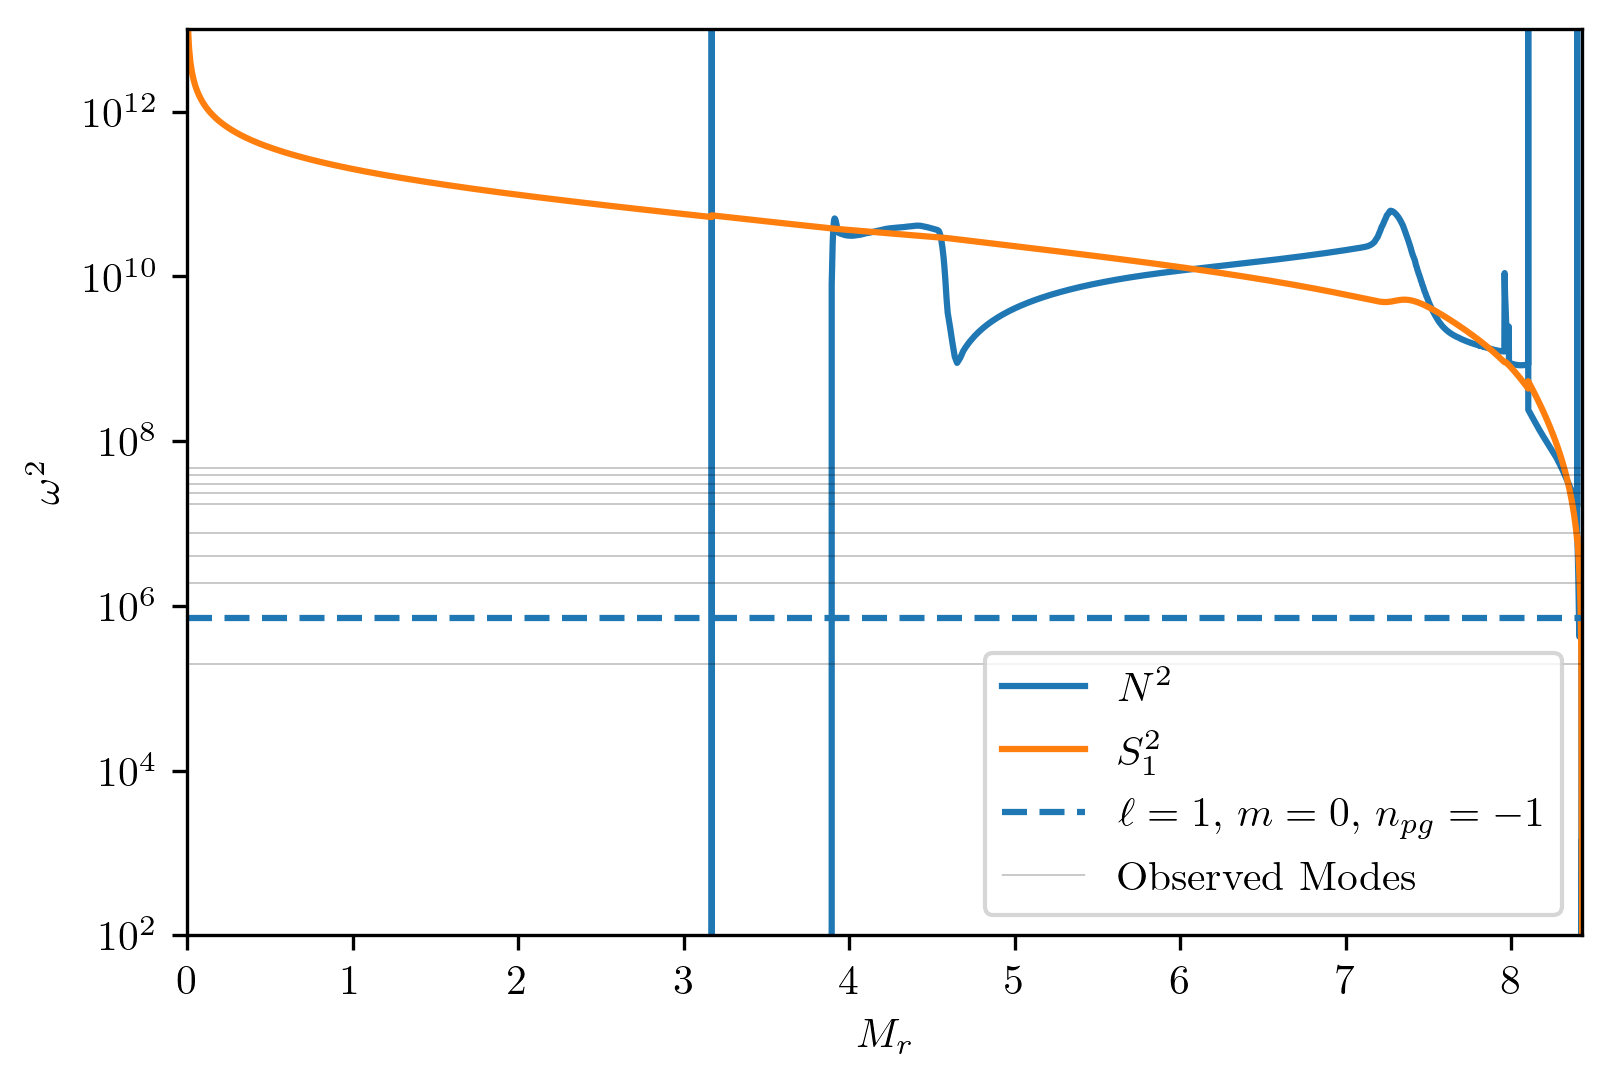

In [48]:
from glob import glob
x = d['x']
V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = 4.0*np.pi*np.pi*d['As']/d['c_1']
d['Sl2'] = 4.0*np.pi*np.pi*l*(l+1)*Gamma_1/(V*c_1)

# Plot the propagation diagram

plt.figure(dpi=300)

plt.plot((d['M_r']*u.gram).to(u.Msun), d['N2'], label='$N^2$')
plt.plot((d['M_r']*u.gram).to(u.Msun), d['Sl2'], label='$S_1^2$')

d = pg.read_output('detail.l1.m+0.n-1.h5')
l = d.meta['l']
m = d.meta['m']
npg = d.meta['n_pg']
omega = d.meta['omega']

plt.axhline(omega.real**2, dashes=(4,2),label=rf'$\ell = {l}$, $m={m}$, $n_{{pg}} = {npg}$')
print(omega)
 
test_tic = 29984014
import h5py as h5
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
tdyn = 20605330.38956768
for i,f in enumerate(f_rad_per_sec):
    label = 'Observed Modes'
    if i != 0:
        label = None
    plt.axhline((f**2.0)*(tdyn**2.0), c='k',lw=0.1,label=label)


plt.xlabel('$M_r$')
plt.ylabel('$\omega^2$')


plt.yscale('log')

plt.legend()

plt.xlim(0,(d['M_r']*u.gram).to(u.Msun).value.max())
plt.ylim(100, 1e13)

plt.savefig('ex_propagation.png',bbox_inches='tight')

In [36]:
f_rad_per_sec.max()

0.00033515309644911994

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, '$\\ell = 1$, $m=0$, $n_{pg} = -1$')

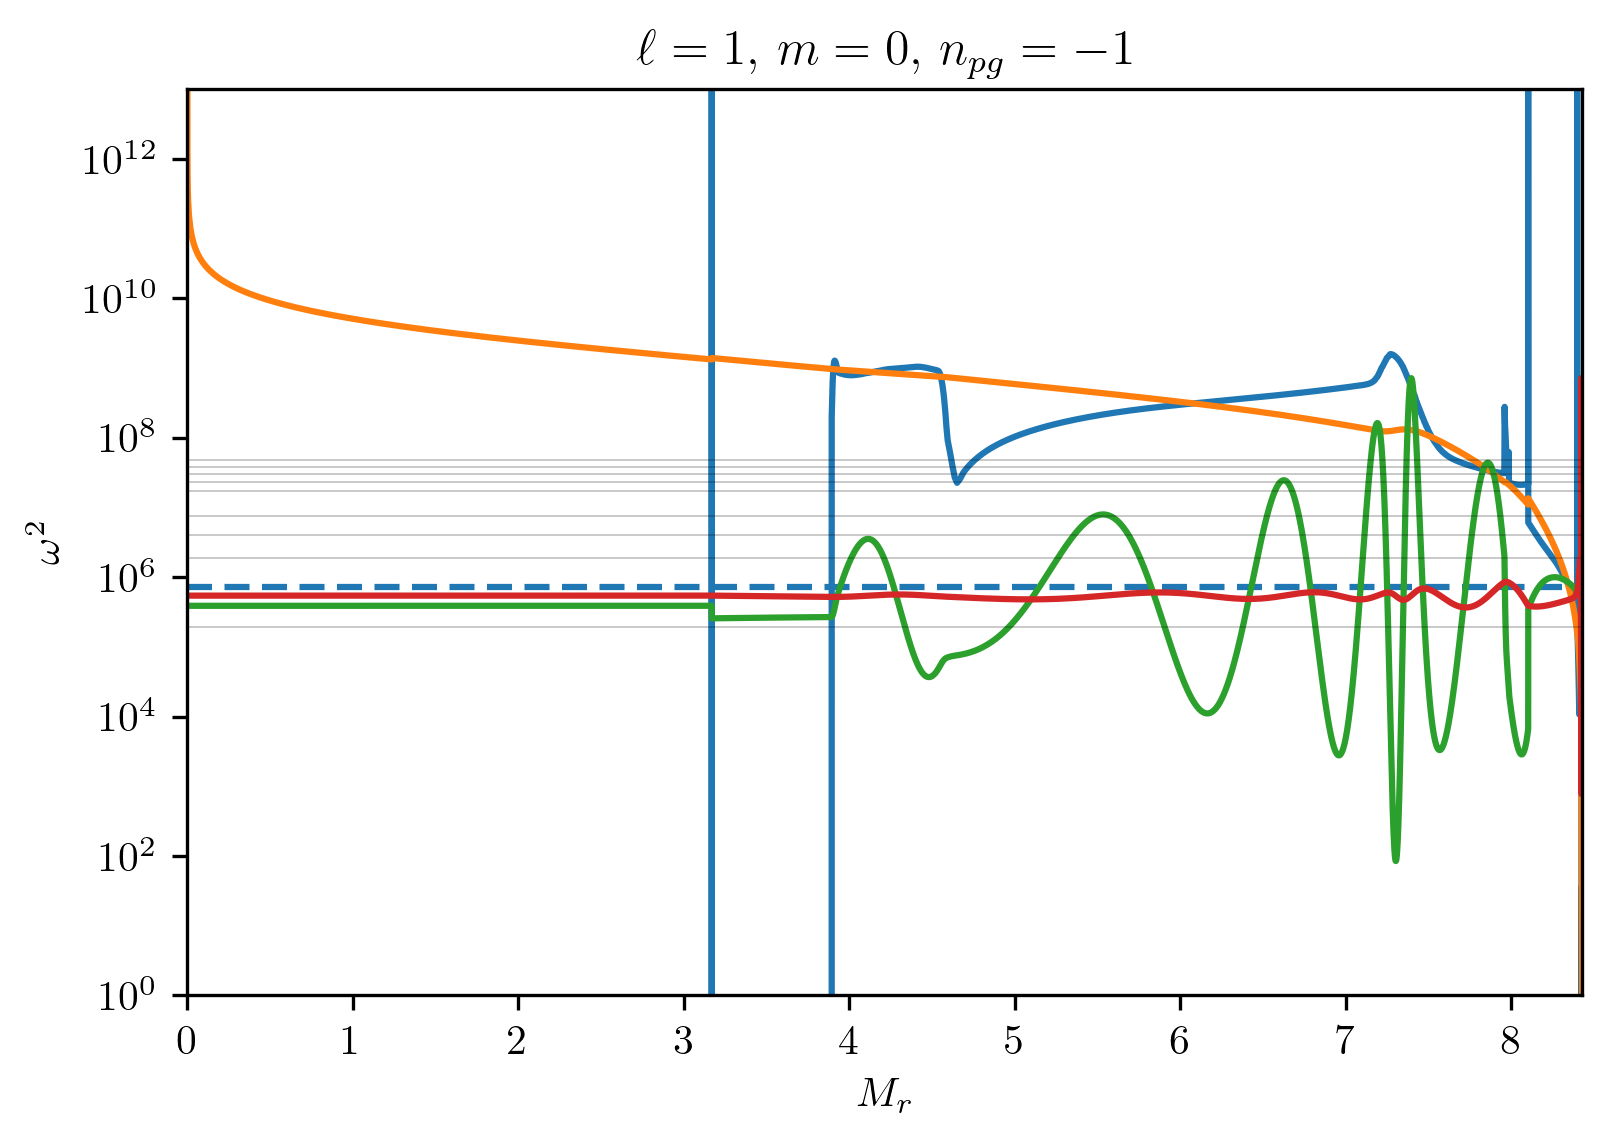

In [89]:
d = pg.read_output('detail.l1.m+0.n-1.h5')

l = d.meta['l']
m = d.meta['m']
npg = d.meta['n_pg']
omega = d.meta['omega']

x = d['x']
V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

# Plot the propagation diagram

plt.figure(dpi=300)

plt.plot((d['M_r']*u.gram).to(u.Msun), d['N2'], label='N^2')
plt.plot((d['M_r']*u.gram).to(u.Msun), d['Sl2'], label='S_l^2')

plt.axhline(omega.real**2, dashes=(4,2))
plt.plot((d['M_r']*u.gram).to(u.Msun),omega.real**2*np.power(10.0,3*d['xi_h'].real/d['xi_h'].real.max()))
plt.plot((d['M_r']*u.gram).to(u.Msun),omega.real**2*np.power(10.0,3*d['xi_r'].real/d['xi_r'].real.max()))
test_tic = 29984014
import h5py as h5
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
tdyn = 20605330.38956768
for f in f_rad_per_sec:
    plt.axhline(f**2.0*tdyn**2.0, c='k',lw=0.1)


plt.xlabel('$M_r$')
plt.ylabel('$\omega^2$')


plt.yscale('log')

plt.xlim(0,(d['M_r']*u.gram).to(u.Msun).value.max())
plt.ylim(1, 1e13)
plt.title(rf'$\ell = {l}$, $m={m}$, $n_{{pg}} = {npg}$')

In [29]:
f_rad_per_sec

NameError: name 'f_rad_per_sec' is not defined

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


(1, 10000000000000.0)

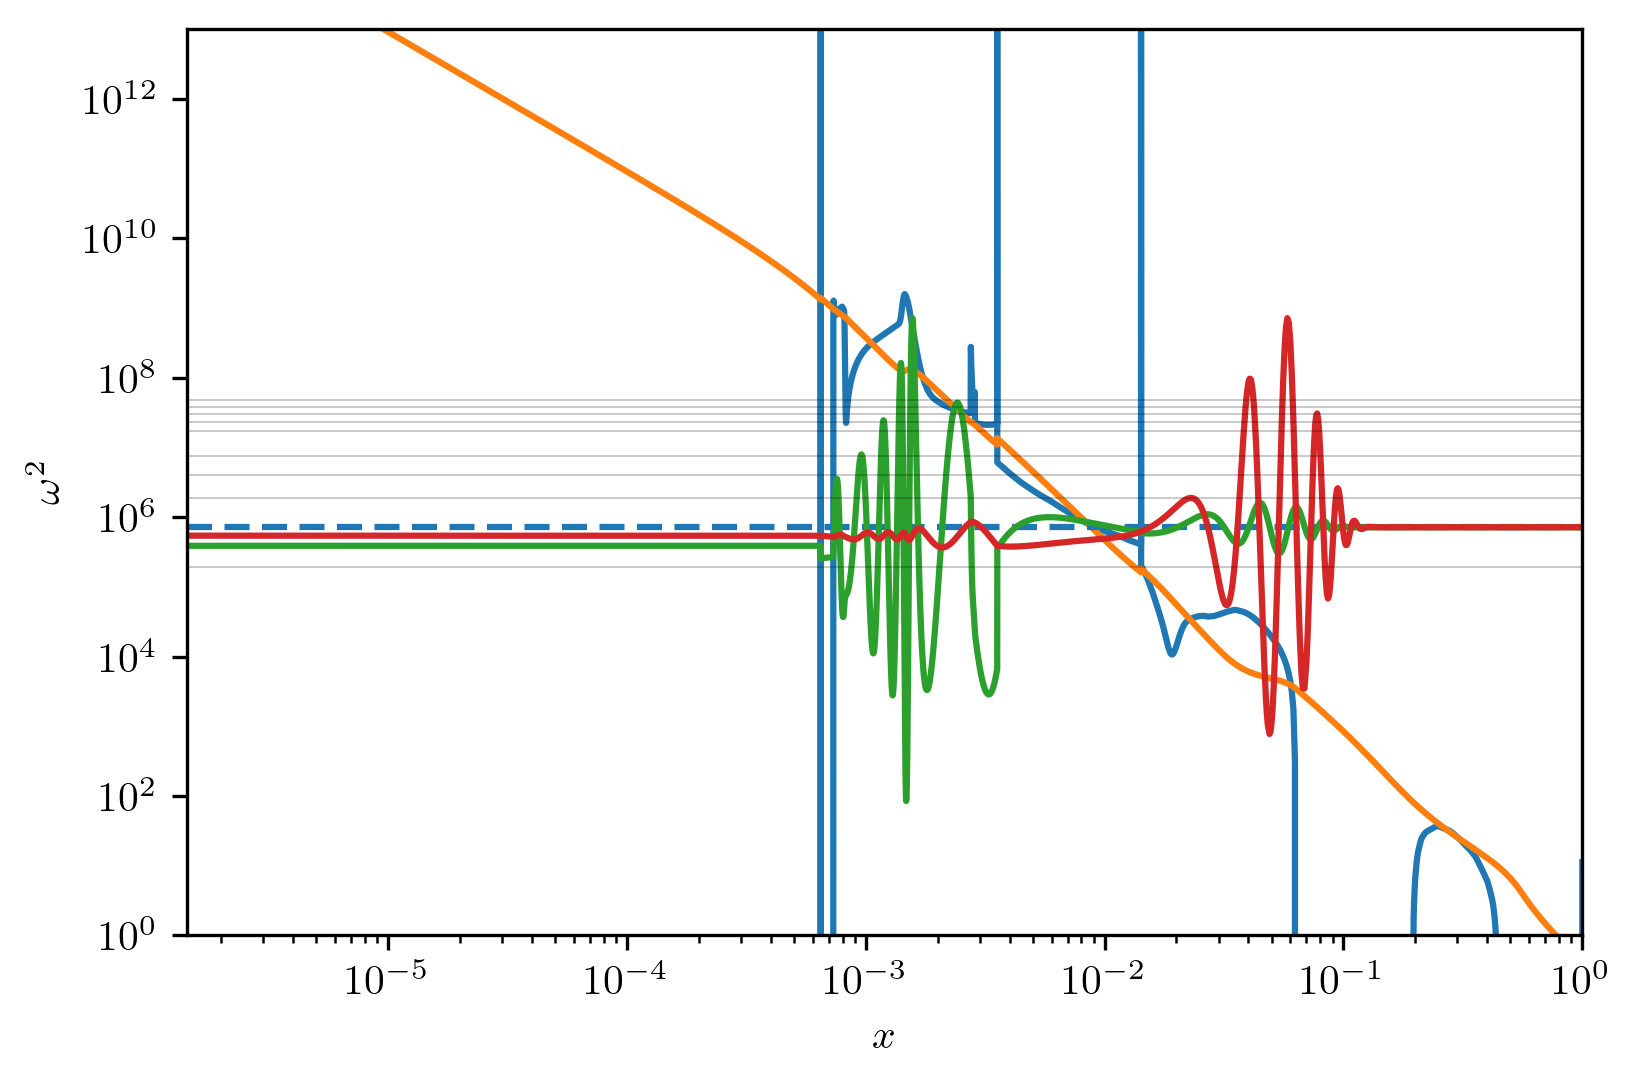

In [51]:
l = d.meta['l']
omega = d.meta['omega']

x = d['x']
V = d['V_2']*d['x']**2
As = d['As']
c_1 = d['c_1']
Gamma_1 = d['Gamma_1']

d['N2'] = d['As']/d['c_1']
d['Sl2'] = l*(l+1)*Gamma_1/(V*c_1)

# Plot the propagation diagram

plt.figure(dpi=300)

plt.plot(d['x'], d['N2'], label='N^2')
plt.plot(d['x'], d['Sl2'], label='S_l^2')

plt.axhline(omega.real**2, dashes=(4,2))
plt.semilogx(d['x'],omega.real**2*np.power(10.0,3*d['xi_h'].real/d['xi_h'].real.max()))
plt.semilogx(d['x'],omega.real**2*np.power(10.0,3*d['xi_r'].real/d['xi_r'].real.max()))
test_tic = 29984014
import h5py as h5
with h5.File('../../TESS/code/prewhitening.hdf5','r') as freqs:
    good_fs = freqs[f'{test_tic}/good_fs'][()][:,0]

f_rad_per_sec = 2*np.pi*good_fs * (u.rad/u.day).to(u.rad/u.second)
tdyn = 20605330.38956768
for f in f_rad_per_sec:
    plt.axhline(f**2.0*tdyn**2.0, c='k',lw=0.1)


plt.xlabel('$x$')
plt.ylabel('$\omega^2$')


plt.yscale('log')

plt.xlim(0,1)
plt.ylim(1, 1e13)

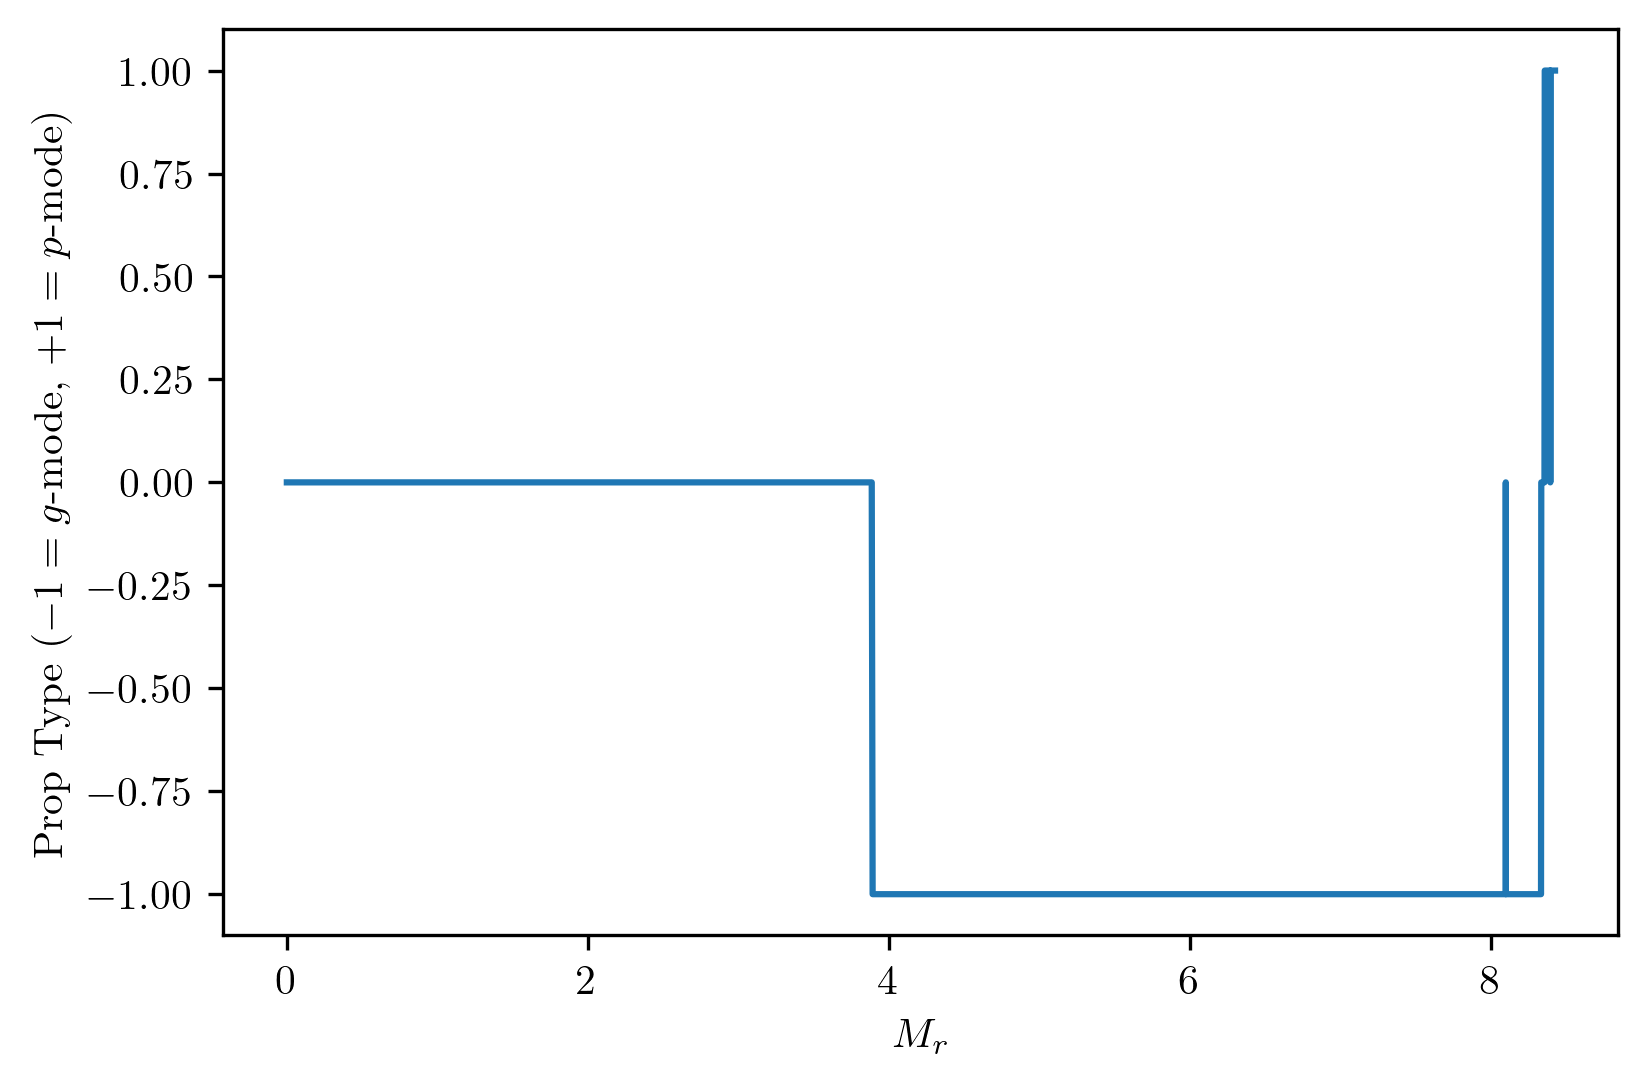

In [50]:
plt.figure(dpi=300)
plt.plot((d['M_r']*u.gram).to(u.Msun),d['prop_type'])

#plt.xlim(8,(d['M_r']*u.gram).to(u.Msun).value.max())
plt.xlabel(r'$M_r$')
plt.ylabel('Prop Type ($-1 = g$-mode, $+1 = p$-mode)')
plt.savefig('prop_type.png')

In [98]:
d.meta

{'l': 1,
 'label': b'',
 'm': 0,
 'n_g': 12,
 'n_p': 11,
 'n_pg': -1,
 'omega': (847.2313014625623+0.02330397854532085j)}